# Optimising Demand Response Strategies for Carbon Intelligent Load Shifting

# Combining ERA5 Datasets

**NOTEBOOK PURPOSE(S):**
* Consolidate the weather data from the ERA5-Land and ERA5-World Datasets
* Preserve the structure of the ERA5-Land Dataset, but fill gaps and add additional variables from the ERA5-World Dataset where necessary.


**LIMITATIONS:**
* This notebook is designed to work with the ERA5 land data downloaded from the hitachi database
* It assumes the data is in the correct format and contains the necessary columns for processing

**NOTEBOOK INPUTS:**
* weather_20250714_1401_processed.parquet
* era5_world_reanalysis_data_2020-2025.parquet


**NOTEBOOK OUTPUTS:**

* Primary output:
    * weather_data_combined_20250714_1401.parquet
* Intermediate outputs:
    * weather_20250714_1401_processed_coordinates.parquet
    * weather_20250714_1401_processed_midnight_filled.parquet
    * weather_20250714_1401_processed_instant_consec_filled.parquet
    * weather_20250714_1401_processed_interval.parquet
    * weather_20250714_1401_processed_filled.parquet
    * (note that these are deleted at the end of the notebook)
    

### Importing Libraries

In [49]:
%matplotlib inline

# ────────────────────────────────────────────────────────────────────────────
# Data Manipulation & Analysis
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import polars as pl
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# Geospatial Data Handling
# ─────────────────────────────────────────────────────────────────────────────
# import xarray as xr
# from xarray.coding.times import CFTimedeltaCoder
import xesmf as xe
import geopandas as gpd
import shapely


# ─────────────────────────────────────────────────────────────────────────────
# Visualization
# ─────────────────────────────────────────────────────────────────────────────
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker

# ─────────────────────────────────────────────────────────────────────────────
# Notebook/Display Tools
# ─────────────────────────────────────────────────────────────────────────────
from IPython.display import display
import matplotlib.pyplot as plt


# ─────────────────────────────────────────────────────────────────────────────
# System / Miscellaneous
# ─────────────────────────────────────────────────────────────────────────────
import os
from datetime import datetime, timedelta
from typing import List, Optional, Union, Dict, Tuple, Sequence, Iterable
from functools import reduce
from zoneinfo import ZoneInfo
from pathlib import Path
import shutil

import concurrent.futures
from tqdm import tqdm
import logging
import re
# import loads
import binascii
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo


## Loading Data

#### Directories

In [2]:
# DIRECTORIES AND PATHs

root_directory = os.path.join('..', '..')
# Base data directory
base_data_directory = os.path.join(root_directory, "data")
# Directory where the dataframes will be saved
hitachi_data_directory = os.path.join(base_data_directory, 'hitachi')

# Directory where the outputs are saved
outputs_directory = os.path.join(root_directory, 'outputs')
outputs_metrics_directory = os.path.join(outputs_directory, 'metrics')
outputs_images_directory = os.path.join(outputs_directory, 'images')

era5_data_directory = os.path.join(base_data_directory, "era5")  # Base directory for ERA5 data

grib_era5_data_directory = os.path.join(era5_data_directory, "grib_downloads")  # Directory where the ERA5 grib files will be saved
parquets_era5_data_directory = os.path.join(era5_data_directory, "parquets")  # Directory where the ERA5 parquet files will be saved
weights_directory = os.path.join(era5_data_directory, "weights")  # Directory where the regridder weights will be saved

In [3]:
print("\n" + "-" * 120)
print(f"Contents of '{base_data_directory}' and subdirectories:\n" + "-" * 120)
for root, dirs, files in os.walk(base_data_directory):
    for f in sorted(files):
        rel_dir = os.path.relpath(root, base_data_directory)
        rel_file = os.path.join(rel_dir, f) if rel_dir != "." else f
        print(f"  - {rel_file}")


------------------------------------------------------------------------------------------------------------------------
Contents of '../../data' and subdirectories:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - optimisation_development/.DS_Store
  - optimisation_development/average_emissions_2022-05-04_to_2022-05-18.parquet
  - optimisation_development/marginal_and_average_emissions_2022-05-04_to_2022-05-18.parquet
  - optimisation_development/marginal_emissions_2022-05-04_to_2022-05-18.parquet
  - optimisation_development/meter_readings_2022-05-01_to_2022-05-14.parquet
  - optimisation_development/meter_readings_2022-05-01_to_2022-05-14_with_marginal_emissions.parquet
  - optimisation_development/meter_readings_2022-05-04_to_2022-05-18.parquet
  - optimisation_development/meter_readings_all_years_20250714_formatted_with_emission_factors_filled.parquet
  - optimisation_development/meter_readi

#### File Paths

In [4]:
# ERA5-Land data
era5_land_weather_filename = "weather_20250714_1401_processed"
era5_land_weather_filepath = os.path.join(hitachi_data_directory, era5_land_weather_filename + ".parquet")

# ERA5-World data
era5_world_weather_filename = "era5_world_reanalysis_data_2020-2025"
era5_world_weather_filepath = os.path.join(era5_data_directory, era5_world_weather_filename + ".parquet")

# Temporary files for intermediate processing
temp_files = []

#### Load and Look at Data

In [5]:
era5_land_weather_pldf = pl.read_parquet(era5_land_weather_filepath)
era5_world_weather_pldf = pl.read_parquet(era5_world_weather_filepath)

In [6]:
# Sample Rows of the DataFrames
print("\n" + "-" * 120)
print(f"Sample rows of ERA5 Land dataset [{era5_land_weather_filename}]:\n" + "-" * 120)
display(era5_land_weather_pldf.sample(8))
display(era5_land_weather_pldf.schema)


------------------------------------------------------------------------------------------------------------------------
Sample rows of ERA5 Land dataset [weather_20250714_1401_processed]:
------------------------------------------------------------------------------------------------------------------------


timestamp,land_latitude,land_longitude,city,precipitation_mm,temperature,wind_speed_mps,wind_direction_meteorological,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2
"datetime[μs, UTC]",f64,f64,cat,f64,f64,f32,f32,f64,f64,f64,f64
2021-03-08 01:00:00 UTC,28.5,76.94,"""delhi""",0.0,18.71228,3.43208,98.387848,0.0,0.0,0.0,0.0
2022-12-20 05:00:00 UTC,28.7,77.24,"""delhi""",0.0,16.908173,1.834298,299.66571,null,null,null,null
2023-07-19 18:00:00 UTC,28.6,77.34,"""delhi""",0.451355,28.534088,1.799197,96.701599,4.5457e6,5.5946e6,1.6365e7,2.0140426e7
2024-05-03 21:00:00 UTC,28.6,76.84,"""delhi""",0.0,26.677338,1.308975,0.744171,5.7859e6,7.4695e6,2.0829324e7,2.6890036e7
2021-08-28 10:00:00 UTC,28.8,76.94,"""delhi""",0.000647,33.382843,1.432095,316.923584,3.4955e6,4.4080e6,1.2583932e7,1.5869e7
2024-07-06 21:00:00 UTC,28.6,77.34,"""delhi""",1.56971,26.026154,2.132437,105.287506,1.7203e6,2.1064e6,6.19296e6,7.5830e6
2023-10-06 14:00:00 UTC,28.4,76.94,"""delhi""",0.0,29.11203,2.587845,49.653259,4.5717e6,5.783835e6,1.6458235e7,2.0821806e7
2023-12-05 12:00:00 UTC,28.6,77.24,"""delhi""",0.0,20.949615,2.635688,338.088684,3.3891e6,3.9475e6,1.2200938e7,1.4211e7


Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('city', Categorical(ordering='physical')),
        ('precipitation_mm', Float64),
        ('temperature', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64)])

In [7]:
print("\n" + "-" * 120)
print(f"Sample rows of ERA5 World dataset [{era5_world_weather_filename}]:\n" + "-" * 120)
display(era5_world_weather_pldf.sample(8))
display(era5_world_weather_pldf.schema)


------------------------------------------------------------------------------------------------------------------------
Sample rows of ERA5 World dataset [era5_world_reanalysis_data_2020-2025]:
------------------------------------------------------------------------------------------------------------------------


timestamp,world_latitude,world_longitude,temperature_celsius,high_cloud_cover,medium_cloud_cover,low_cloud_cover,surface_net_solar_radiation_j_m2,surface_solar_radiation_downwards_j_m2,surface_net_solar_radiation_kwh,surface_solar_radiation_downwards_kwh,total_cloud_cover,total_precipitation_mm,wind_speed,wind_direction,wind_u_component,wind_v_component
"datetime[μs, UTC]",f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32
2023-10-29 19:00:00 UTC,18.0,73.800003,20.523529,0.0,0.07663,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.07663,0.0,2.163838,73.254852,-2.072082,-0.623434
2022-10-27 15:00:00 UTC,19.200001,70.599998,28.239563,0.0,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.0,0.0,4.10091,42.566437,-2.774038,-3.020293
2020-07-04 03:00:00 UTC,18.6,73.300003,25.342377,0.971283,0.932373,0.93338,54367.957031,64079.980469,0.015102,0.0178,1.0,10.414589,3.906718,231.604919,3.061878,2.426386
2025-05-02 06:00:00 UTC,20.4,70.199997,29.270355,0.0,0.0,0.0,3.1022e6,3.223932e6,0.861715,0.895537,0.0,0.0,3.713463,293.897186,3.395122,-1.504311
2020-12-09 04:00:00 UTC,26.9,75.800003,17.62326,0.0,0.0,0.0,880144.75,1.1202e6,0.244485,0.31117,0.0,0.0,1.191648,204.325226,0.490858,1.085856
2022-11-16 14:00:00 UTC,18.799999,71.400002,27.457123,0.0,0.0,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.0,0.0,5.619206,18.339203,-1.768037,-5.333809
2021-06-07 20:00:00 UTC,28.799999,75.900002,31.879211,0.0,0.01001,0.0,3.6000e-12,0.0,1.0000e-18,0.0,0.01001,0.0,2.198057,242.095047,1.942478,1.028705
2020-02-04 04:00:00 UTC,19.4,73.800003,18.769501,0.0,0.106689,0.017822,1.0409e6,1.2305e6,0.289136,0.341806,0.117859,0.0,0.319477,76.51413,-0.310669,-0.074504


Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature_celsius', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('surface_net_solar_radiation_j_m2', Float64),
        ('surface_solar_radiation_downwards_j_m2', Float64),
        ('surface_net_solar_radiation_kwh', Float64),
        ('surface_solar_radiation_downwards_kwh', Float64),
        ('total_cloud_cover', Float32),
        ('total_precipitation_mm', Float64),
        ('wind_speed', Float32),
        ('wind_direction', Float32),
        ('wind_u_component', Float32),
        ('wind_v_component', Float32)])

## Processing Data

### Helper Functions

In [8]:
def cleanup_temp_dir(temp_dir: Path):
    """
    Clean up the temporary directory by removing it and logging the action.

    Parameters:
    -----------
    temp_dir : Path
        The path to the temporary directory to be deleted.

    Returns:
    --------
    None
    """
    shutil.rmtree(temp_dir)
    logging.info(f"Deleted temporary directory: {temp_dir}")

#### Geospatial Helper Functions

In [9]:
def wkb_to_coords(hex_wkb: str):
    """
    Convert a hex WKB string to coordinates (x, y).
    Uses binascii to decode the hex string and shapely's load function to convert WKB to a Point object.

    Parameters:
    ----------
    hex_wkb : str
        Hexadecimal string representing the WKB (Well-Known Binary) format of a point.

    Returns:
    -------
    tuple
        A tuple containing the x and y coordinates of the point, or (None, None)
        if the conversion fails.
    """
    try:
        point = loads(binascii.unhexlify(hex_wkb))
        return point.x, point.y
    except Exception:
        return None, None


In [10]:
def find_nearest_geometry(
        point: shapely.geometry.Point,
        input_gdf: gpd.GeoDataFrame,
        input_sindex=None,
        return_column="geometry"
) -> Tuple[shapely.geometry.Point, float] | Tuple[None, None] :
    """
    Finds the nearest geometry from input_gdf to the provided point.

    Parameters:
    ----------
    point : shapely.geometry.Point
        The point to search from.
    input_gdf : GeoDataFrame
        The GeoDataFrame containing geometries to match the point to.
    input_sindex : spatial index, optional
        Precomputed spatial index of input_gdf (default = None).
        If None, it will compute the spatial index on-the-fly.
    return_column : str
        Column name to return from the matched row (default = 'geometry').

    Returns:
    -------
    Tuple[shapely.geometry, float]
        A tuple containing the nearest geometry and the distance to it.
        If no geometry is found, returns (None, None).
    """
    try:
        if candidate_sindex is None:
            candidate_sindex = input_gdf.sindex

        idx = list(candidate_sindex.nearest(point.bounds, 1))[0]
        nearest_row = input_gdf.iloc[idx]
        nearest_geom = nearest_row.geometry
        return nearest_geom, point.distance(nearest_geom)

    except Exception as e:
        print(f"Error finding nearest for point {point}: {e}")
        return None, None


#### Transformations

In [11]:
def deaccumulate_land_data_lazy(
        lf: pl.LazyFrame,
        accum_vars: Optional[List[str]] = None,
        timestamp_col: str = "timestamp",
        location_cols: List[str] = ["land_longitude", "land_latitude"],
        start_hour: int = 2,                     # first hour to *emit* a deaccumulated increment
        audit_col: str = "deaccumulated data",
        clip_non_negative_for: Optional[Iterable[str]] = None,
) -> pl.LazyFrame:
    """
    Convert daily-reset cumulative variables to hourly increments.

    Parameters:
    ------------
    lf: pl.LazyFrame
        containing the data to deaccumulate.
    accum_vars: Optional[List[str]]
        list of variables to deaccumulate (default: all cumulative vars).
    timestamp_col: str
        name of the timestamp column (default: "timestamp").
    location_cols: List[str]
        names of the location columns (default: ["land_longitude", "land_latitude"]).
    start_hour: int
        first hour to *emit* a deaccumulated increment (default: 2).
    audit_col: str
        name of the audit column (default: "deaccumulated data").
    clip_non_negative_for: Optional[Iterable[str]]
        extra columns to clip >= 0 (default: None).

    Returns:
    ------------
    pl.LazyFrame
        A LazyFrame with deaccumulated variables added.

    Rules:
    - For each day/location, compute diff(var - lag(var)) within the day.
    - Emit NULL for hours < start_hour (default 2).
    - For hour == start_hour, emit the *current cumulative* (no subtraction).
    - For hour > start_hour, emit the diff.
    - If source var is NULL, result is NULL.
    - Clip negatives to 0 for radiation + precipitation (+ any provided in `clip_non_negative_for`).
    - Append audit tags where we actually write a deacc value.

    Notes:
    - Assumes timestamps are UTC and hourly.
    """

    lf = ensure_audit(lf, audit_col)

    default_vars = [
        "precipitation_mm",
        "surface_net_solar_radiation_kWh_per_m2",
        "surface_solar_radiation_downwards_kWh_per_m2",
        "surface_net_solar_radiation_joules_per_m2",
        "surface_solar_radiation_downwards_joules_per_m2",
    ]
    if accum_vars is None:
        accum_vars = [c for c in default_vars if c in lf.collect_schema().names()]
    else:
        accum_vars = [c for c in accum_vars if c in lf.collect_schema().names()]
    if not accum_vars:
        return lf

    # Columns to clip non-negative
    clip_cols = set(clip_non_negative_for or [])
    for v in accum_vars:
        if v.startswith("surface_") or v == "precipitation_mm":
            clip_cols.add(f"deacc_{v}")

    # Add helpers
    lf = lf.with_columns([
        pl.col(timestamp_col).dt.hour().alias("__hour__"),
        pl.col(timestamp_col).dt.date().alias("__date__"),
    ])

    # Build updates & audits
    updates = []
    audit_updates = []

    for var in accum_vars:
        lag_val = pl.col(var).shift(1).over(location_cols + ["__date__"])
        prev_null = lag_val.is_null()

        diff_expr = pl.col(var) - lag_val
        safe_diff = pl.when(prev_null).then(None).otherwise(diff_expr)

        # Main deaccumulation expression
        expr = (
            pl.when(pl.col(var).is_null())
              .then(None)
            .when(pl.col("__hour__") < start_hour)
              .then(None)
            .when(pl.col("__hour__") == start_hour)
              .then(pl.col(var))
            .otherwise(safe_diff)
        )

        # Inline clipping if needed
        if f"deacc_{var}" in clip_cols:
            expr = pl.when(expr < 0).then(0).otherwise(expr)

        updates.append(expr.alias(f"deacc_{var}"))

        # Audit only if value is non-null
        wrote_mask = pl.col(f"deacc_{var}").is_not_null()
        audit_updates.append(
            pl.when(wrote_mask)
              .then(
                  pl.col(audit_col).list.concat([
                      pl.struct(
                          column=pl.lit(f"deacc_{var}"),
                          method=pl.lit("deaccumulate_land")
                      )
                  ])
              )
              .otherwise(pl.col(audit_col))
              .alias(audit_col)
        )

    # Apply data updates
    lf = lf.with_columns(updates)

    # Apply audits one-by-one (avoids duplicate alias error)
    for audit_expr in audit_updates:
        lf = lf.with_columns(audit_expr)

    # Drop helpers
    return lf.drop(["__hour__", "__date__"])

In [12]:
def create_interval_columns_lazy(
        lf: pl.LazyFrame,
        accum_vars: List[str],
        timestamp_col: str = "timestamp",
        location_cols: List[str] = ["land_longitude", "land_latitude"],
        start_hour: int = 2
) -> pl.LazyFrame:
    """
    Create per-hour interval columns from original cumulative + deaccumulated values.

    Parameters
    ----------
    lf : pl.LazyFrame
        Data containing cumulative and deaccumulated columns.
    accum_vars : List[str]
        Original cumulative variable names (without 'deacc_' prefix).
    timestamp_col : str
        Name of timestamp column.
    location_cols : List[str]
        Columns defining a location (used to avoid cross-location mixing).
    start_hour : int
        First hour to use deaccumulated increments.

    Returns
    -------
    pl.LazyFrame
        With additional `interval_...` columns.
    """

    # Add helpers for hour/date (drop later)
    lf = lf.with_columns([
        pl.col(timestamp_col).dt.hour().alias("__hour__"),
        pl.col(timestamp_col).dt.date().alias("__date__"),
    ])

    interval_updates = []

    for var in accum_vars:
        deacc_col = f"deacc_{var}"
        if deacc_col not in lf.collect_schema().names():
            continue

        interval_expr = (
            pl.when(pl.col("__hour__") < start_hour)
              .then(pl.col(var))
              .otherwise(pl.col(deacc_col))
              .over(location_cols + ["__date__"])
              .alias(f"interval_{var}")
        )
        interval_updates.append(interval_expr)

    lf = lf.with_columns(interval_updates)

    return lf.drop(["__hour__", "__date__"])


In [13]:
def fill_interval_from_world_lazy(
        land_lf: pl.LazyFrame,
        world_lf: pl.LazyFrame,
        interval_to_world: dict[str, str],
        *,
        audit_col: str = "gap_filling",
        overwrite_non_null: bool = False,
        land_timestamp_col: str = "timestamp",
        world_timestamp_col: str = "timestamp",
        land_world_key_cols: list[str] = ["world_longitude", "world_latitude"],
        world_grouping_cols: list[str] = ["world_longitude", "world_latitude"],
        dedupe_world: bool = True,
        align_world_keys_to_float32: bool = True,
        align_timestamps_tz: str | None = "UTC",   # set to None to skip, else e.g. "UTC"
        only_rows_with_nulls: bool = True,
) -> pl.LazyFrame:
    """
    Fill missing interval columns in land data using corresponding world data.

    Parameters:
    -----------
    land_lf : pl.LazyFrame
        LazyFrame containing land data with cumulative or deaccumulated variables.
    world_lf : pl.LazyFrame
        LazyFrame containing world data with weather variables.
    interval_to_world: dict[str, str]
        Mapping from land interval columns to world columns.
    audit_col : str
        Name of the column to use for auditing changes.
    overwrite_non_null : bool
        Whether to overwrite non-null values in the land data.
    land_timestamp_col : str
        Name of the column containing land timestamps.
    world_timestamp_col: str
        Name of the column containing world timestamps.
    land_world_key_cols: list[str]
        List of key columns in the land data that correspond to the world data.
    world_grouping_cols: list[str]
        List of grouping columns in the world data that correspond to the land data.
    dedupe_world: bool
        Whether to deduplicate the world data.
    align_world_keys_to_float32: bool
        Whether to align world key columns to float32.
    align_timestamps_tz: str | None
        Timezone to align timestamps to, or None to skip.
    only_rows_with_nulls: bool
        Whether to only fill rows with nulls.

    Returns:
    --------
    pl.LazyFrame
        LazyFrame with land data updated with world intervals.
    """
    # ensure audit column exists
    land_lf = ensure_audit(land_lf, audit_col)

    land_names  = set(land_lf.collect_schema().names())
    world_names = set(world_lf.collect_schema().names())

    # keep valid pairs
    interval_to_world = {k: v for k, v in interval_to_world.items()
                         if (k in land_names) and (v in world_names)}
    if not interval_to_world:
        return land_lf

    interval_cols = list(interval_to_world.keys())
    land_keys  = [land_timestamp_col, *land_world_key_cols]
    world_keys = [world_timestamp_col, *world_grouping_cols]

    # timezone alignment (optional)
    if align_timestamps_tz:
        land_lf  = land_lf.with_columns(pl.col(land_timestamp_col).dt.convert_time_zone(align_timestamps_tz))
        world_lf = world_lf.with_columns(pl.col(world_timestamp_col).dt.convert_time_zone(align_timestamps_tz))

    # small LAND slice
    land_slice = land_lf.select([c for c in (land_keys + interval_cols + [audit_col]) if c in land_names])

    # filter to only rows that actually need filling (unless overwriting)
    if only_rows_with_nulls and not overwrite_non_null:
        need_mask = pl.any_horizontal([pl.col(c).is_null() for c in interval_cols])
        land_slice = land_slice.filter(need_mask)

    # if nothing to fill, bail early
    # (avoids building needless joins)
    maybe_empty = land_slice.select(pl.len().alias("_n")).collect().item()
    if maybe_empty == 0:
        return land_lf

    # tiny WORLD slice
    need_world = list(dict.fromkeys(interval_to_world.values()))
    world_slice = world_lf.select([c for c in (world_keys + need_world) if c in world_names])

    # semi-join WORLD by the *timestamps we actually need* (massive shrink)
    ts_needed = land_slice.select(pl.col(land_timestamp_col)).unique()
    world_slice = world_slice.join(
        ts_needed.rename({land_timestamp_col: world_timestamp_col}),
        on=[world_timestamp_col],
        how="semi"
    )

    # optional type align on coord keys
    if align_world_keys_to_float32:
        land_slice = land_slice.with_columns([pl.col(c).cast(pl.Float32) for c in land_world_key_cols if c in land_names])
        world_slice = world_slice.with_columns([pl.col(c).cast(pl.Float32) for c in world_grouping_cols if c in world_names])

    if dedupe_world:
        world_slice = world_slice.unique(subset=world_keys, keep="first")

    # join
    j = land_slice.join(
        world_slice,
        left_on=land_keys,
        right_on=world_keys,
        how="left",
        validate="m:1",
    )

    # updates + single audit alias
    updates = []
    audit_expr = pl.col(audit_col)
    for interval_col, world_col in interval_to_world.items():
        mask = (pl.col(world_col).is_not_null()
                if overwrite_non_null
                else (pl.col(interval_col).is_null() & pl.col(world_col).is_not_null()))
        updates.append(
            pl.when(mask).then(pl.col(world_col)).otherwise(pl.col(interval_col)).alias(interval_col)
        )
        audit_expr = pl.when(mask).then(
            audit_expr.list.concat([pl.struct(column=pl.lit(interval_col), method=pl.lit("world_fill_interval"))])
        ).otherwise(audit_expr)

    j_filled = j.with_columns(updates + [audit_expr.alias(audit_col)])

    # merge back coalescing only the changed columns
    small_out = j_filled.select(land_keys + interval_cols + [audit_col]).rename(
        {c: f"__filled__{c}" for c in (interval_cols + [audit_col])}
    )
    merged = land_lf.join(small_out, on=land_keys, how="left")

    return (
        merged
        .with_columns([pl.coalesce([pl.col(f"__filled__{c}"), pl.col(c)]).alias(c) for c in (interval_cols + [audit_col])])
        .drop([f"__filled__{c}" for c in (interval_cols + [audit_col])])
    )


#### Data Quality Checks

##### Eager Functions

In [14]:
def analyze_null_patterns(
        df: pl.DataFrame,
        colname: str,
        grouping_cols: list[str] = ["land_longitude", "land_latitude"]
) -> pl.DataFrame:
    """
    Analyze null patterns in a specified column of a DataFrame.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to analyze.
    colname : str
        The name of the column to analyze for null patterns.
    grouping_cols : list, optional
        List of columns to group by (default is ["land_longitude", "land_latitude"]).

    Returns:
    -------
    pl.DataFrame
        A DataFrame containing the following columns:
        - grouping_cols: The columns used for grouping.
        - f"{colname}_total_nulls": Total number of nulls in the specified column.
        - f"{colname}_isolated_nulls": Number of isolated nulls in the specified column.
        - f"{colname}_gaps": List of structs containing start and end timestamps of gaps longer than 1 hour.
    """
    df = df.sort(grouping_cols + ["timestamp"])
    all_locs = df.select(grouping_cols).unique()

    flagged = (
        df.with_columns([
            pl.col(colname).is_null().alias("is_null"),
            pl.col(colname).shift(1).over(grouping_cols).is_null().fill_null(False).alias("previous_is_null"),
            pl.col(colname).shift(-1).over(grouping_cols).is_null().fill_null(False).alias("next_is_null"),
        ])
        .with_columns((pl.col("is_null") & ~pl.col("previous_is_null") & ~pl.col("next_is_null")).alias("is_isolated_null"))
    )

    basic_stats = (
        flagged.group_by(grouping_cols).agg([
            pl.col("is_null").sum().cast(pl.UInt32).alias(f"{colname}_total_nulls"),
            pl.col("is_isolated_null").sum().cast(pl.UInt32).alias(f"{colname}_isolated_nulls"),
        ])
    )

    runs = (
        flagged
        .with_columns(pl.col(colname).is_null().alias("is_null"))
        .with_columns(((pl.col("is_null") != pl.col("is_null").shift(1)).cum_sum().over(grouping_cols)).alias("run_id"))
    )

    gap_intervals = (
        runs.filter(pl.col("is_null"))
            .group_by(grouping_cols + ["run_id"])
            .agg([pl.col("timestamp").first().alias("gap_start"),
                  pl.col("timestamp").last().alias("gap_end")])
            .filter((pl.col("gap_end") - pl.col("gap_start")) > pl.duration(hours=1))
            .group_by(grouping_cols)
            .agg(pl.struct(["gap_start","gap_end"]).implode().alias(f"{colname}_gaps"))
    )

    return (all_locs
        .join(basic_stats, on=grouping_cols, how="left")
        .join(gap_intervals, on=grouping_cols, how="left")
        .with_columns(pl.col(f"{colname}_gaps").fill_null([])))


In [15]:
# Completeness report
def compute_completeness(
        df: pl.DataFrame,
        grouping_col: str,
        columns_to_check: List[str]
) -> pl.DataFrame:
    """
    Compute per‐group completeness counts and ratios for a set of columns.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to analyze.
    grouping_col : str
        The column to group by (e.g., "location").
    columns_to_check : List[str]
        List of column names to check for completeness.

    Returns:
    -------
    pl.DataFrame
        A DataFrame with completeness statistics for each group.
        generated columns:
        - total_rows: Total number of rows in each group.
        - {col}_non_null: Count of non-null values in each specified column.
        - {col}_completeness: Ratio of non-null values to total rows for each column.
        - avg_completeness: Average completeness across all specified columns.
        - min_completeness: Minimum completeness across all specified columns.
        - max_completeness: Maximum completeness across all specified columns.
    """
    # 1) basic counts
    completeness = df.group_by(grouping_col).agg([
        pl.len().alias("total_rows"),
        *[pl.col(col).is_not_null().sum().alias(f"{col}_non_null")
          for col in columns_to_check]
    ])

    # 2) add ratios
    for col in columns_to_check:
        completeness = completeness.with_columns([
            (pl.col(f"{col}_non_null") / pl.col("total_rows"))
              .alias(f"{col}_completeness")
        ])

    # 3) summary stats across completeness columns
    comp_cols = [f"{col}_completeness" for col in columns_to_check]
    completeness = completeness.with_columns([
        pl.mean_horizontal([pl.col(c) for c in comp_cols])
          .alias("avg_completeness"),
        pl.min_horizontal([pl.col(c) for c in comp_cols])
          .alias("min_completeness"),
        pl.max_horizontal([pl.col(c) for c in comp_cols])
          .alias("max_completeness"),
    ])

    return completeness


In [16]:
def completeness_transform_long(
        completeness_df: pl.DataFrame,
        grouping_col: str,
        columns_to_check: List[str]
) -> pd.DataFrame:
    """
    Take the output of compute_completeness and pivot it into long form
    for plotting (one row per group+variable).

    Parameters:
    ----------
    completeness_df : pl.DataFrame
        The DataFrame containing completeness statistics.
    grouping_col : str
        The column used for grouping (e.g., "location").
    columns_to_check : List[str]
        List of column names to check for completeness.

    Returns:
    -------
    pd.DataFrame
        A Pandas DataFrame in long format with the following columns:
        - grouping_col: The column used for grouping (e.g., "location").
        - column: The name of the column for which completeness is measured.
        - completeness: The completeness ratio (0.0–1.0).
    """
    # Create expected completeness columns
    # Handle string or list for grouping_col
    if isinstance(grouping_col, str):
        group_cols = [grouping_col]
    else:
        group_cols = grouping_col

    # Construct expected completeness column names
    comp_cols = [f"{col}_completeness" for col in columns_to_check]

    # Validate columns exist
    existing_cols = set(completeness_df.columns)
    required_cols = group_cols + comp_cols
    missing_cols = [col for col in required_cols if col not in existing_cols]

    if missing_cols:
        raise KeyError(f"The following required columns are missing from completeness_df: {missing_cols}")

    # Convert to pandas
    pdf = completeness_df.select(required_cols).to_pandas()

    # Melt to long format
    long = pdf.melt(
        id_vars=group_cols,
        value_vars=comp_cols,
        var_name="column",
        value_name="completeness"
    )
    long["completeness_pct"] = long["completeness"] * 100
    return long

In [17]:
def get_irregular_intervals(
        df: pl.DataFrame,
        grouping_cols: list,
        timestamp_col: str = "timestamp"
) -> pl.DataFrame:
    """
    Identify irregular intervals in the timestamp column within each group.

    Parameters
    ----------
    df : pl.DataFrame
        The input DataFrame containing the data.
    grouping_cols : list
        List of columns to group by.
    timestamp_col : str, optional
        The name of the timestamp column. Default is "timestamp".

    Returns
    -------
    pl.DataFrame
        A DataFrame summarizing the irregular intervals for each group.
        It includes the grouping columns, timestamp column, and the time difference in seconds.
        The DataFrame is sorted by the grouping columns and timestamp column.
    """
    df = df.sort(grouping_cols + [timestamp_col])

    df = df.with_columns([
        pl.col(timestamp_col)
        .diff()
        .over(grouping_cols)
        .alias("time_delta")
    ])

    df = df.with_columns([
        pl.col("time_delta").dt.total_seconds().alias("time_delta_sec")
    ])

    return (
        df.select(grouping_cols + [timestamp_col, "time_delta_sec"])
    )

In [18]:
def validate_timestamp_frequency(
        df: pl.DataFrame,
        grouping_cols: list,
        timestamp_col: str = "timestamp",
        expected_freq: str = "1h"
) -> pl.DataFrame:
    """
    Validates if timestamps within each group follow a regular frequency.

    Parameters
    ----------
    df : pl.DataFrame
        The input DataFrame containing the data.
    grouping_cols : list
        List of columns to group by.
    timestamp_col : str, optional
        The name of the timestamp column. Default is "timestamp".
    expected_freq : str, optional
        The expected frequency of the timestamps (e.g., "1h", "30min"). Default is "1h".
        infer the frequency from the data.

    Returns
    -------
    pl.DataFrame
        A DataFrame summarizing the frequency check results for each group.
    """
    df = df.sort(grouping_cols + [timestamp_col])

    # Compute time diffs
    df = df.with_columns([
        pl.col(timestamp_col)
        .diff()
        .over(grouping_cols)
        .alias("time_delta")
    ])

    df = df.with_columns([
        pl.col("time_delta").dt.total_seconds().alias("time_delta_sec")
    ])

    # Summarize: count unique time deltas per group
    freq_check = (
        df.group_by(grouping_cols)
        .agg([
            pl.col("time_delta_sec").n_unique().alias("n_unique_intervals"),
            pl.col("time_delta_sec").mode().alias("most_common_interval"),
        ])
        .with_columns([
            (pl.col("n_unique_intervals") == 1).alias("is_regular")
        ])
    )
    return freq_check

##### Lazy Functions

In [19]:
def analyze_null_patterns_lazy(
        df: pl.LazyFrame,
        colname: str,
        grouping_cols: List[str]
) -> pl.LazyFrame:
    """
    Analyze null patterns in a specified column of a LazyFrame.
    This function identifies isolated nulls, counts total nulls, and detects gaps longer than 1 hour.

    Parameters:
    ----------
    df : pl.LazyFrame
        The LazyFrame to analyze.
    colname : str
        The name of the column to analyze for null patterns.
    grouping_cols : List[str]
        List of columns to group by (default is ["weather_longitude", "weather_latitude"])

    Returns:
    -------
    pl.LazyFrame
        A LazyFrame containing the following columns:
        - grouping_cols: The columns used for grouping.
        - f"{colname}_total_nulls": Total number of nulls in the specified column.
        - f"{colname}_isolated_nulls": Number of isolated nulls in the specified column.
        - f"{colname}_gaps": List of structs containing start and end timestamps of gaps longer than 1 hour.
    """
    prefix = f"{colname}_analysis_"
    renamed_cols = [f"{prefix}{c}" for c in grouping_cols]

    # Rename grouping columns to avoid join collisions
    df_renamed = df.with_columns([
        pl.col(c).alias(rc) for c, rc in zip(grouping_cols, renamed_cols)
    ])

    # Isolate null flag outside groupby
    flagged = df_renamed.sort(renamed_cols + ["timestamp"]).with_columns([
        pl.col(colname).is_null().alias("is_null"),
        pl.col(colname).shift(1).over(renamed_cols).is_null().alias("prev_null"),
        pl.col(colname).shift(-1).over(renamed_cols).is_null().alias("next_null"),
    ]).with_columns([
        (pl.col("is_null") & ~pl.col("prev_null") & ~pl.col("next_null")).alias("is_isolated_null")
    ])

    # Aggregate isolated + total nulls
    basic_stats = flagged.group_by(renamed_cols).agg([
        pl.col("is_null").sum().cast(pl.UInt32).alias(f"{colname}_total_nulls"),
        pl.col("is_isolated_null").sum().cast(pl.UInt32).alias(f"{colname}_isolated_nulls")
    ])

    # Gap detection
    gaps = (
        df_renamed.filter(pl.col(colname).is_null())
        .with_columns([
            (pl.col("timestamp") != pl.col("timestamp").shift(1).over(renamed_cols) + pl.duration(hours=1))
            .cast(pl.UInt8)
            .cum_sum()
            .over(renamed_cols)
            .alias("gap_id")
        ])
        .group_by(renamed_cols + ["gap_id"])
        .agg([
            pl.col("timestamp").first().alias("gap_start"),
            pl.col("timestamp").last().alias("gap_end")
        ])
        .filter((pl.col("gap_end") - pl.col("gap_start")) > pl.duration(hours=1))
        .group_by(renamed_cols)
        .agg([
            pl.struct(["gap_start", "gap_end"]).implode().alias(f"{colname}_gaps")
        ])
    )

    # Final merge
    result = (
        df_renamed.select(renamed_cols).unique()
        .join(basic_stats, on=renamed_cols, how="left")
        .join(gaps, on=renamed_cols, how="left")
        .with_columns(pl.col(f"{colname}_gaps").fill_null([]))
    )

    return result

In [20]:
def compute_completeness_lazy(
        df: pl.LazyFrame,
        grouping_col: str,
        columns_to_check: List[str]
) -> pl.LazyFrame:
    """
    Lazy version of completeness report computation.
    Parameters and return values are the same as compute_completeness(),
    but operates on and returns a LazyFrame.

    Parameters:
    ----------
    df : pl.LazyFrame
        The LazyFrame to analyze.
    grouping_col : str
        The column to group by (e.g., "location").
    columns_to_check : List[str]
        List of column names to check for completeness.

    Returns:
    -------
    pl.LazyFrame
        A LazyFrame with completeness statistics for each group.
    """
    # Basic counts in a single aggregation
    completeness = df.group_by(grouping_col).agg([
        pl.len().alias("total_rows"),
        *[pl.col(col).is_not_null().sum().alias(f"{col}_non_null")
          for col in columns_to_check],
        *[(pl.col(col).is_not_null().sum() / pl.len()).alias(f"{col}_completeness")
          for col in columns_to_check]
    ])

    # Summary stats in a single operation
    comp_cols = [f"{col}_completeness" for col in columns_to_check]
    completeness = completeness.with_columns([
        pl.mean_horizontal([pl.col(c) for c in comp_cols]).alias("avg_completeness"),
        pl.min_horizontal([pl.col(c) for c in comp_cols]).alias("min_completeness"),
        pl.max_horizontal([pl.col(c) for c in comp_cols]).alias("max_completeness")
    ])

    return completeness


In [21]:
def completeness_transform_long_lazy(
        completeness_lf: pl.LazyFrame,
        grouping_col: Union[str, List[str]],
        columns_to_check: List[str]
) -> pd.DataFrame:
    """
    Lazy-friendly version of completeness_transform_long.

    It validates and selects relevant columns lazily, then collects
    and melts the result into long format using pandas.

    Parameters:
    ----------
    completeness_lf : pl.LazyFrame
        LazyFrame output from compute_completeness_lazy.
    grouping_col : str or List[str]
        The column(s) used for grouping (e.g., "location").
    columns_to_check : List[str]
        List of column names for completeness.

    Returns:
    -------
    pd.DataFrame
        Pandas DataFrame in long format:
        - grouping_col
        - column: which column the completeness ratio is for
        - completeness: ratio (0.0–1.0)
        - completeness_pct: percentage (0–100)
    """
    # Normalize group columns
    group_cols = [grouping_col] if isinstance(grouping_col, str) else grouping_col
    comp_cols = [f"{col}_completeness" for col in columns_to_check]
    required_cols = group_cols + comp_cols

    # Lazy select + collect
    selected = completeness_lf.select(required_cols).collect()

    # Convert to pandas and melt
    pdf = selected.to_pandas()

    long = pdf.melt(
        id_vars=group_cols,
        value_vars=comp_cols,
        var_name="column",
        value_name="completeness"
    )
    long["completeness_pct"] = long["completeness"] * 100
    return long


In [22]:
def count_isolated_nulls_lazy(
        ldf: pl.LazyFrame,
        colname: str,
        grouping_cols: list = ["weather_longitude", "weather_latitude"]
) -> pl.LazyFrame:
    """
    Lazy version of the function to count isolated nulls in a specified column.
    An isolated null is one where both the previous and next values are non-null
    within a group sorted by timestamp.

    Parameters:
    ----------
    ldf : pl.LazyFrame
        The LazyFrame to process.
    colname : str
        The column to check for isolated nulls.
    grouping_cols : list
        The columns to group by, default is location coordinates.

    Returns:
    -------
    pl.LazyFrame
        A LazyFrame with the count of isolated nulls per group.
    """

    # Sort first by group, then timestamp
    sorted_ldf = ldf.sort(grouping_cols + ["timestamp"])

    # Create shifted null flags within groups
    flagged = (
        sorted_ldf.with_columns([
            pl.col(colname).is_null().alias("is_null"),
            pl.col(colname).shift(1).over(grouping_cols)
            .is_null().alias("prev_null"),
            pl.col(colname).shift(-1).over(grouping_cols)
            .is_null().alias("next_null"),
        ])
        .with_columns([
            (pl.col("is_null") & ~pl.col("prev_null")
             & ~pl.col("next_null"))
            .alias("is_isolated_null")
        ])
    )

    # Aggregate the number of isolated nulls
    result = (
        flagged.group_by(grouping_cols)
        .agg(
            pl.col("is_isolated_null")
            .sum()
            .cast(pl.UInt32)
            .alias(f"{colname}_isolated_nulls")
        )
    )
    return result

In [ ]:
def parallelisation_wrapper_null_analysis(
        filepath: str,
        columns: List[str],
        grouping_cols: List[str],
        output_dir: Path,
        worker_threads: int=1
) -> List[Path]:
    """
    Process multiple columns in parallel using Polars LazyFrames.
    This function reads a Parquet file, processes each specified column
    to analyze null patterns, and writes the results to separate Parquet files.

    Parameters:
    ----------
    filepath : str
        Path to the input Parquet file containing the data.
    columns : List[str]
        List of column names to process for null pattern analysis.
    grouping_cols : List[str]
        List of columns to group by during analysis (e.g., location coordinates).
    output_dir : Path
        Directory where the output Parquet files will be saved.
    worker_threads : int, optional
        Number of worker threads to use for parallel processing. Default is 1.

    Returns:
    -------
    List[Path]
        List of paths to the output Parquet files for each processed column.
    """
    # Ensure output directory is a Path object
    output_dir = Path(output_dir)

    # Create output directory if it doesn't exist
    if not output_dir.exists():
        logging.info(f"Creating output directory: {output_dir}")
    else:
        logging.info(f"Output directory already exists: {output_dir}")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Read the Parquet file as a LazyFrame - including caching for performance
    df = pl.scan_parquet(filepath).cache()

    # looping the columns to process
    logging.info(f"Starting processing of {len(columns)} columns...")
    with concurrent.futures.ThreadPoolExecutor(max_workers=worker_threads) as executor:
        # Submit tasks for each column to process and write results
        futures = {
            executor.submit(run_and_save_null_analysis, col, df.clone(), output_dir, grouping_cols): col
            for col in columns
        }
        results = []

        # Collect results as they complete
        for future in tqdm(


            ent.futures.as_completed(futures), total=len(futures), desc="Progress:"):
            result = future.result()
            if result:
                results.append(result)

    logging.info("All columns processed.")

    return results

In [24]:
def run_and_save_null_analysis(
        colname: str,
        df: pl.LazyFrame,
        output_dir: Path,
        grouping_cols: List[str]
) -> Optional[Path]:
    """
    Process a specific column in a LazyFrame to analyze null patterns and write results to a Parquet file.

    Parameters:
    ----------
    colname : str
        The name of the column to analyze for null patterns.
    df : pl.LazyFrame
        The LazyFrame containing the data.
    output_dir : Path
        The directory where the output Parquet file will be saved.
    grouping_cols : List[str]
        List of columns to group by for the analysis.

    Returns:
    -------
    Optional[Path]
        The path to the output Parquet file if successful, or None if an error occurs.
    """
    try:
        logging.info(f"\nProcessing: {colname}")
        # Analyze null patterns in the specified column
        metrics = analyze_null_patterns_lazy(df, colname, grouping_cols)
        # Define the output file path
        outfile = output_dir / f"{colname}_nulls.parquet"
        # Write the results to a Parquet file
        metrics.sink_parquet(outfile, engine="streaming")
        return outfile
    except Exception as e:
        logging.error(f"Failed on {colname}: {e}")
        return None

In [25]:
def read_and_join_null_analyses(
        files: List[Path],
        grouping_cols: List[str]
) -> Optional[pl.LazyFrame]:
    """
    Read multiple Parquet files as LazyFrames, rename columns, and join them
    on specified grouping columns. This function handles potential schema mismatches
    and missing columns gracefully, logging errors as they occur.

    Parameters
    ----------
    files : List[Path]
        List of Path objects pointing to the Parquet files to read.
    grouping_cols : List[str]
        List of columns to group by for the join operation.

    Returns
    -------
    Optional[pl.LazyFrame]
        A LazyFrame resulting from the join of all input files on the specified grouping columns.
        Returns None if no valid frames are found or if an error occurs during processing.
    """
    lazy_frames = []

    for file in tqdm(files, desc="Loading result files"):
        colname = file.stem.replace("_nulls", "")
        prefix = f"{colname}_analysis_"
        try:
            schema = pl.read_parquet(file).schema
        except Exception as e:
            logging.error(f"Failed to read schema from {file.name}: {e}")
            continue

        rename_map = {f"{prefix}{c}": c for c in grouping_cols if f"{prefix}{c}" in schema}

        lf = pl.scan_parquet(file)

        if rename_map:
            lf = lf.rename(rename_map)

        gap_col = f"{colname}_gaps"
        if gap_col in schema:
            lf = lf.with_columns([
                pl.col(gap_col).fill_null([]).list.sort().alias(gap_col)
            ])

        # Only include if all grouping cols are now present
        try:
            if all(c in lf.collect_schema().keys() for c in grouping_cols):
                lazy_frames.append(lf)
            else:
                logging.warning(f"Skipping {file.name} due to missing grouping cols.")
        except Exception as e:
            logging.error(f"Failed to validate schema for {file.name}: {e}")

    if not lazy_frames:
        logging.error("No valid frames to join. Returning None.")
        return None

    joined = lazy_frames[0]
    for i, lf in enumerate(lazy_frames[1:], start=1):
        joined = joined.join(lf, on=grouping_cols, how="full", suffix=f"_{i}")

    return joined

#### Imputations

In [26]:
def record_events(
        df: pl.DataFrame,
        mask: pl.Expr,
        grouping_cols: List[str],
        column_name: str,
        method: str = "avg_of_neighbors",
) -> pl.DataFrame:
    """
    Given `df` and a boolean expression `mask`, return a DataFrame
    of (longitude, latitude, timestamp, column, method) for every row
    where mask is True.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to filter and select from.
    mask : pl.Expr
        A boolean expression to filter the DataFrame.
    group_cols : List[str]
        List of columns to group by (e.g., ["weather_longitude", "weather_latitude"]).
    column_name : str
        The name of the column to be recorded.
    method : str, optional
        The method used for the column, default is "avg_of_neighbors".

    Returns:
    -------
    pl.DataFrame
        A DataFrame containing the specified columns filtered by the mask.
    """
    df = df.sort(grouping_cols + ["timestamp"])
    return (
        df
        .filter(mask)
        .select(
            *grouping_cols,
            "timestamp",
            pl.lit(column_name).alias("column"),
            pl.lit(method).alias("method"),
        )
    )

In [27]:
def apply_imputation(
        df: pl.DataFrame,
        mask: pl.Expr,
        colname: str,
        grouping_cols: List[str],
) -> pl.DataFrame:
    """
    Impute `colname` in `df` wherever `mask` is True (averaging
    the previous/next values _within_ each group).

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to process.
    mask : pl.Expr
        A boolean expression to filter the DataFrame.
    colname : str
        The name of the column to be imputed.
    grouping_cols : List[str]
        List of columns to group by (e.g., ["weather_longitude", "weather_latitude"]).

    Returns:
    -------
    pl.DataFrame
        A DataFrame with the specified column imputed where the mask is True.
    """
    df = df.sort(grouping_cols + ["timestamp"])

    filled = (
        (pl.col(colname).shift(1).over(grouping_cols) +
         pl.col(colname).shift(-1).over(grouping_cols)) / 2
    )
    return df.with_columns(
        pl.when(mask)
          .then(filled)
          .otherwise(pl.col(colname))
          .alias(colname)
    )

In [28]:
def impute_isolated_nulls(
        df: pl.DataFrame,
        columns: List[str],
        grouping_cols: List[str],
) -> (pl.DataFrame, pl.DataFrame):
    """
    For each column in `columns`, detect isolated nulls within each
    group (by longitude/latitude), record an event, then impute.

    Parameters:
    ----------
    df : pl.DataFrame
        The DataFrame to process.
    columns : List[str]
        List of column names to check for isolated nulls.
    grouping_cols : List[str]
        List of columns to group by (e.g., ["weather_longitude", "weather_latitude"]).

    Returns:
    -------
    (pl.DataFrame, pl.DataFrame)
        A tuple containing:
        - The DataFrame with imputed values.
        - A DataFrame of events, with columns: (longitude, latitude, timestamp, column, method).

    """
    df = df.sort(grouping_cols + ["timestamp"])

    dev = df.clone()
    events = []
    for col in columns:
        # 1) build the mask
        mask = (
            pl.col(col).is_null() &
            ~pl.col(col).shift(1).over(grouping_cols).is_null() &
            ~pl.col(col).shift(-1).over(grouping_cols).is_null()
        )
        # 2) record
        events.append(record_events(dev, mask, grouping_cols, col))
        # 3) impute
        dev = apply_imputation(dev, mask, col, grouping_cols)

    # 4) combine all per-row events
    all_events = pl.concat(events)
    row_events = (
        all_events
        .group_by(grouping_cols + ["timestamp"])
        .agg(
            pl.struct(["column", "method"])
              .implode()
              .alias("gap_filling")
        )
    )
    return dev, row_events

In [29]:
def impute_consecutive_gaps(
        base_filepath : str,
        filler_filepath : str,
        output_filepath : str,
        mapping: Dict[str,str],
        join_base : Union[str, Sequence[str]] = ["timestamp","era5_latitude","era5_longitude"],
        join_fill : Union[str, Sequence[str]] = ["timestamp","latitude","longitude"],
        group_cols : Sequence[str] = ["weather_longitude","weather_latitude"],
        min_gap : Dict[str,int] = {"hours":1},
        fill_method: str = "consecutive_fill_era5"
) -> None:
    """
    Function to perform imputation of consecutive gaps in weather data using ERA5 data.
    This is meant to be run and is distinct from the isolated nulls imputation.

    Parameters:
    ----------
    base_filepath : str
        Path to the base weather data file (e.g., "weather_imputed.parquet").
    filler_filepath : str
        Path to the filler ERA5 data file (e.g., "era5_data.parquet").
    output_filepath : str
        Path where the output file will be saved (e.g., "weather_imputed_era5_filled.parquet").
    mapping : Dict[str,str]
        A dictionary mapping the base dataset column names to the filler dataset column names.
        Example: {"temperature": "era5_temperature", "wind_speed": "era5_wind_speed"}
    join_base : Union[str, Sequence[str]], optional
        Columns to join on from the base weather data. Default is ["era5_longitude", "era5_latitude", "timestamp"].
    join_fill : Union[str, Sequence[str]], optional
        Columns to join on from the filler ERA5 data. Default is ["longitude", "latitude", "timestamp"].
    group_cols : Sequence[str], optional
        Columns to group by for gap detection. Default is ["weather_longitude", "weather_latitude"].
    min_gap : Dict[str,int], optional
        Minimum gap duration to consider for filling, specified as a dictionary with time units.
    fill_method: str, optional
        The method to use for filling gaps. Default is "consecutive_fill_era5".

    Returns:
    -------
    None
        Writes the imputed and gap-filled data to the specified output file.
    """

    #----------------------------------------------------------------
    # Input Validation
    #----------------------------------------------------------------

    # Normalise join keys - convert to lists if single strings
    if isinstance(join_base, str):
        join_base = [join_base]
    if isinstance(join_fill, str):
        join_fill = [join_fill]

    # Ensure join keys are of the same length
    if len(join_base) != len(join_fill):
        raise ValueError("join_base and join_fill must match in length")

    #----------------------------------------------------------------
    # Lazy Scan and Joins
    #----------------------------------------------------------------

    lazy_scan_base = pl.scan_parquet(base_filepath)

    # Lazy scan the filler data and select relevant columns
    lazy_scan_filler = (
        pl.scan_parquet(filler_filepath)
        .select(join_fill + list(mapping.values()))
    )
    # Join the base and filler dataframes on the specified keys
    joined_data = lazy_scan_base.join(
        lazy_scan_filler,
        left_on=join_base,
        right_on=join_fill,
        how="left",
    )
    #----------------------------------------------------------------
    # Adding is_null flags for each mapping column
    #----------------------------------------------------------------

    flagged_nulls = joined_data.with_columns([
        pl.col(col).is_null().alias(f"is_null__{col}")
        for col in mapping
    ])

    # Collect into eager DataFrame and execute the the lazy operations
    data = flagged_nulls.collect()
    data = data.sort(group_cols + ["timestamp"])

    #----------------------------------------------------------------
    # Generating Flags for Filling
    #----------------------------------------------------------------

    # In eager mode, compute run_id, ts_first, ts_last, long_gap flags
    for base_col in mapping:
        null_flag = f"is_null__{base_col}"  # flag for null values in the base column
        run_col = f"run_id__{base_col}"     # run ID for consecutive null/non-null runs
        first_col = f"ts_first__{base_col}"     # timestamp of first entry in the run
        last_col = f"ts_last__{base_col}"       # timestamp of last entry in the run
        gap_col = f"long_gap__{base_col}"       # flag for runs longer than min_gap

        # Loop through data and compute run IDs
        # Assigns a run id to each consecutive run of null/non-null values, incrementing when the null flag changes
        data = data.with_columns([
            (
                (pl.col(null_flag) != pl.col(null_flag).shift(1))
                .cum_sum()
                .over(group_cols)
            ).alias(run_col)
        ])
        # Identify the first and last timestamp of each run
        data = data.with_columns([
            pl.col("timestamp").first().over(group_cols + [run_col]).alias(first_col),
            pl.col("timestamp").last().over(group_cols + [run_col]).alias(last_col),
        ])
        # Flag runs longer than min_gap
        data = data.with_columns([
            ((pl.col(last_col) - pl.col(first_col)) >= pl.duration(**min_gap))
            .alias(gap_col)
        ])

    #----------------------------------------------------------------
    # Fill gaps and annotate
    #----------------------------------------------------------------

    for base_col, fill_col in mapping.items():
        null_flag = f"is_null__{base_col}"
        gap_flag = f"long_gap__{base_col}"
        right_name = f"{fill_col}_right"  # name for the filler column in the right join
        fill_source = right_name if right_name in data.columns else fill_col

        # Create a mask for filling
        mask = (
            pl.col(null_flag) &     # base column is null
            pl.col(gap_flag) &      # long gap in base column
            pl.col(fill_source).is_not_null()      # filler column is not null
        )
        # Fill missing values in the base column with the filler column
        data = data.with_columns([
            # fill missing with filler column where mask is True
            pl.when(mask).then(pl.col(fill_source)).otherwise(pl.col(base_col)).alias(base_col),
            # record event
            pl.when(mask)
              .then(pl.lit([{"column": base_col, "method": fill_method}]))
              .otherwise(pl.lit([]))
              .alias(f"evt__{base_col}"),
        ])

    #-----------------------------------------------------------------
    # Cleanup
    #-----------------------------------------------------------------

    # concatenate all event columns into a single list column
    data = data.with_columns(
        pl.concat_list([f"evt__{c}" for c in mapping]).alias("gap_filling")
    )

    # Drop helper columns and filler-only join keys
    cols_to_drop = []
    cols_to_drop += [c for c in join_fill if c not in join_base and c in data.columns]
    cols_to_drop += [
        *[f"is_null__{c}" for c in mapping],
        *[f"run_id__{c}" for c in mapping],
        *[f"ts_first__{c}" for c in mapping],
        *[f"ts_last__{c}" for c in mapping],
        *[f"long_gap__{c}" for c in mapping],
        *[f"evt__{c}" for c in mapping],
    ]
    cols_to_drop += [
        col for col in mapping.values()
        if col not in mapping.keys() and col in data.columns
    ]
    cols_to_drop += [col for col in data.columns if col.endswith("_right")]

    cols_to_drop = list(dict.fromkeys(cols_to_drop))  # remove duplicates
    final_data = data.drop(*cols_to_drop)

    #-----------------------------------------------------------------
    # Save result
    #-----------------------------------------------------------------
    os.makedirs(os.path.dirname(output_filepath), exist_ok=True)
    final_data.write_parquet(
        output_filepath,
        compression="snappy",
        statistics=True,
    )
    print(f"Wrote gap‑filled, event‑annotated data to: {output_filepath}")

In [30]:
def impute_consecutive_gaps_lazy(
        land_lf: pl.LazyFrame,
        world_lf: pl.LazyFrame,
        mapping: Dict[str, str],             # {land_col: world_col}
        min_gap: Dict[str, int] = {"hours": 1},
        audit_col: str = "gap_filling",
        # keys for run detection (LAND station identity)
        land_grouping_cols: List[str] = ["land_longitude", "land_latitude"],
        # join keys (timestamp + WORLD coords present in LAND)
        land_world_key_cols: List[str] = ["world_longitude", "world_latitude"],
        world_grouping_cols: List[str] = ["world_longitude", "world_latitude"],
        land_timestamp_col: str = "timestamp",
        world_timestamp_col: str = "timestamp",
        align_world_keys_to_float32: bool = True,      # cast both sides world coord keys to Float32
) -> pl.LazyFrame:
    """
    Fill gaps in LAND data using WORLD data based on specified mappings.
    This function performs a left join between LAND and WORLD data on specified keys,
    identifies gaps in LAND data, and fills them with corresponding values from WORLD data
    where applicable. It also records the filling method in an audit column.


    Parameters:
    ----------
    land_lf : pl.LazyFrame
        LazyFrame containing LAND data with columns to fill.
    world_lf : pl.LazyFrame
        LazyFrame containing WORLD data with columns to use for filling.
    mapping : Dict[str, str]
        A dictionary mapping LAND column names to WORLD column names.
        Example: {"temperature": "world_temperature", "wind_speed": "world_wind_speed"}
    min_gap : Dict[str, int], optional
        Minimum gap duration to consider for filling, specified as a dictionary with time units.
        Default is {"hours": 1}.
    audit_col : str, optional
        The name of the column to store audit information about the filling method.
        Default is "gap_filling".
    land_grouping_cols : List[str], optional
        List of columns to group by in LAND data (e.g., ["land_longitude", "land_latitude"]).
        These columns are used to identify unique LAND stations.
        Default is ["land_longitude", "land_latitude"].
    land_world_key_cols : List[str], optional
        List of columns to join on from LAND data that correspond to WORLD coordinates.
        These columns should match the WORLD coordinates in the mapping.
        Default is ["world_longitude", "world_latitude"].
    world_grouping_cols : List[str], optional
        List of columns to group by in WORLD data (e.g., ["world_longitude",
        "world_latitude"]). These columns are used to identify unique WORLD stations.
        Default is ["world_longitude", "world_latitude"].
    land_timestamp_col : str, optional
        The name of the timestamp column in LAND data. Default is "timestamp".
    world_timestamp_col : str, optional
        The name of the timestamp column in WORLD data. Default is "timestamp".

    Returns:
    -------
    pl.LazyFrame
        A LazyFrame with the LAND data filled using WORLD values where applicable.

    """
    land_lf = ensure_audit(land_lf, audit_col)

    land_names  = set(land_lf.collect_schema().names())
    world_names = set(world_lf.collect_schema().names())

    # Only keep mappings that exist in both frames
    mapping = {lc: wc for lc, wc in mapping.items() if lc in land_names and wc in world_names}
    if not mapping:
        return land_lf  # nothing to do

    # Minimal WORLD slice
    need_world = list(dict.fromkeys(mapping.values()))
    wkeep = [world_timestamp_col, *world_grouping_cols, *need_world]
    world_min = world_lf.select([c for c in wkeep if c in world_names])

    if align_world_keys_to_float32:
        land_world_cast = [pl.col(c).cast(pl.Float32) for c in land_world_key_cols if c in land_names]
        world_world_cast = [pl.col(c).cast(pl.Float32) for c in world_grouping_cols if c in world_names]
        land_base = land_lf.with_columns(land_world_cast)
        world_min = world_min.with_columns(world_world_cast)
    else:
        land_base = land_lf

    # Join LAND with WORLD on (timestamp + world_* coords)
    land_join_keys  = [land_timestamp_col, *land_world_key_cols]
    world_join_keys = [world_timestamp_col, *world_grouping_cols]
    j = (
        land_base
        .sort(land_grouping_cols + [land_timestamp_col])  # required for shift/cumsum runs
        .join(
            world_min,
            left_on=land_join_keys,
            right_on=world_join_keys,
            how="left",
            validate="m:1",
        )
    )

    # ---- Stage 1: is_null/NaN + run_id ----
    stage1 = []
    for base_col in mapping:
        is_null_expr = pl.col(base_col).is_null() | pl.col(base_col).is_nan()
        is_null = is_null_expr.alias(f"__is_null__{base_col}")
        run_id = (
            (is_null_expr != is_null_expr.shift(1))
            .cum_sum()
            .over(land_grouping_cols)
            .alias(f"__run_id__{base_col}")
        )
        stage1 += [is_null, run_id]
    j = j.with_columns(stage1)

    # ---- Stage 2: run length (count of consecutive nulls) + first/last ts (optional) ----
    stage2 = []
    for base_col in mapping:
        run = f"__run_id__{base_col}"
        run_len = (
            pl.when(pl.col(f"__is_null__{base_col}"))
            .then(1).otherwise(0)
            .sum()
            .over(land_grouping_cols + [run])
            .alias(f"__run_len__{base_col}")
        )
        # keep the ts bounds too if you like, but run_len is what we'll use:
        ts_first = pl.col(land_timestamp_col).first().over(land_grouping_cols + [run]).alias(f"__ts_first__{base_col}")
        ts_last  = pl.col(land_timestamp_col).last().over(land_grouping_cols + [run]).alias(f"__ts_last__{base_col}")
        stage2 += [run_len, ts_first, ts_last]
    j = j.with_columns(stage2)

    # ---- Stage 3: long_gap via row-count threshold (e.g., >= 3 rows for 3h) ----
    min_run_rows = max(1, (min_gap.get("days",0)*24) + min_gap.get("hours",0))  # since it’s hourly
    stage3 = []
    for base_col in mapping:
        long_gap = (pl.col(f"__run_len__{base_col}") >= min_run_rows).alias(f"__long_gap__{base_col}")
        stage3.append(long_gap)
    j = j.with_columns(stage3)

    # ---- Stage 4: apply fills + single combined audit update ----
    updates, masks = [], {}
    for base_col, world_col in mapping.items():
        mask = (
            pl.col(f"__is_null__{base_col}") &
            pl.col(f"__long_gap__{base_col}") &
            pl.col(world_col).is_not_null()
        )
        masks[base_col] = mask
        updates.append(
            pl.when(mask).then(pl.col(world_col)).otherwise(pl.col(base_col)).alias(base_col)
        )

    audit_expr = pl.col(audit_col)
    for base_col, mask in masks.items():
        audit_expr = pl.when(mask).then(
            audit_expr.list.concat([
                pl.struct(column=pl.lit(base_col), method=pl.lit("world_lookup_longgap"))
            ])
        ).otherwise(audit_expr)

    j = j.with_columns(updates + [audit_expr.alias(audit_col)])

    # ---- Final projection: keep ONLY original LAND columns (drops helpers/world extras) ----
    land_cols_final = list(land_lf.collect_schema().names())  # order preserved
    return j.select(land_cols_final)

In [31]:
def ensure_audit(
        lf: pl.LazyFrame,
        audit_col="gap_filling"
) -> pl.LazyFrame:
    """
    Ensure that the LazyFrame has an audit column for gap filling events.
    If the audit column does not exist, it will be created as an empty list of structs.

    Parameters:
    ----------
    lf : pl.LazyFrame
        The LazyFrame to check and potentially modify.
    audit_col : str, optional
        The name of the audit column to ensure. Default is "gap_filling".

    Returns:
    -------
    pl.LazyFrame
        The LazyFrame with the audit column present. If the column was not present,
        it will be added as an empty list of structs.
    """
    # If already has the audit column, return as is
    names = set(lf.collect_schema().names())

    if audit_col in names:
        return lf

    # Otherwise, create the audit column as an empty list of structs
    return lf.with_columns(
        pl.lit([])
        .cast(pl.List(
                      pl.Struct(
                               [pl.Field("column", pl.Utf8),
                                       pl.Field("method", pl.Utf8)]
                            )
                    )
        )
        .alias(audit_col)
    )


In [32]:
def fill_midnight_pass(
        land_lf: pl.LazyFrame,
        world_lf: pl.LazyFrame,
        land_columns_to_fill: List[str],
        land_to_world_field_map: Dict[str, str],
        audit_col: str = "gap_filling",
        overwrite_non_null: bool = False,
        land_grouping_cols: List[str] = ["land_longitude", "land_latitude"],
        land_world_key_cols: list[str] = ["world_longitude", "world_latitude"],
        world_grouping_cols: List[str] = ["world_longitude", "world_latitude"],
        land_timestamp_col: str = "timestamp",
        world_timestamp_col: str = "timestamp",
        target_hour: Union[int, Iterable[int]] = 0,   # 0 = midnight; can pass [0, 12], etc.
) -> pl.LazyFrame:
    """
    Fill LAND values at specific hour(s) from WORLD via explicit join on
    (land_timestamp_col + land_grouping_cols) ↔ (world_timestamp_col + world_grouping_cols).

    By default, only fills when LAND is NULL. If overwrite_non_null=True, also overwrites
    non-nulls. Always logs a warning when overwriting *would* occur for visibility.

    Parameters:
    ----------
    land_lf : pl.LazyFrame
        The LazyFrame containing land data with potential missing values at midnight.
    world_lf : pl.LazyFrame
        The LazyFrame containing world data to fill in missing values.
    land_columns_to_fill : List[str]
        A list of land measurement columns that need to be filled with world data.
    land_to_world_field_map : Dict[str, str]
        A mapping from land measurement columns to world measurement columns.
        This is used to ensure that the correct values are filled from the world data.
    audit_col : str, optional
        The name of the audit column to track gap filling events. Default is "gap_filling".
    overwrite_non_null : bool, optional
        If True, non-null values at midnight will be overwritten with world data.
        If False, only null values will be filled. Default is False.
    land_grouping_cols : List[str], optional
        The columns used to group the land data. Default is ["land_longitude", "land_latitude"].
    world_grouping_cols : List[str], optional
        The columns used to group the world data. Default is ["world_longitude", "world_latitude"].
    land_timestamp_col : str, optional
        The name of the timestamp column in the land LazyFrame. Default is "timestamp".
    world_timestamp_col : str, optional
        The name of the timestamp column in the world LazyFrame. Default is "timestamp".

    Returns:
    -------
    pl.LazyFrame
        A LazyFrame with missing values at midnight filled using world data,
        and the audit column updated with the methods used for filling.
    """

    # normalize target_hour to list
    if isinstance(target_hour, int):
        hours = [target_hour]
    else:
        hours = list(target_hour)

    land_lf = ensure_audit(land_lf, audit_col)
    land_names = set(land_lf.collect_schema().names())
    world_names = set(world_lf.collect_schema().names())

    cols_to_fill = [c for c in land_columns_to_fill if c in land_names]
    world_needed = [land_to_world_field_map[c] for c in cols_to_fill if land_to_world_field_map.get(c) in world_names]
    if not world_needed:
        return land_lf

    # >>> use LAND's world_* keys on the left, not land_longitude/lat
    land_join_keys  = [land_timestamp_col, *land_world_key_cols]
    world_join_keys = [world_timestamp_col, *world_grouping_cols]

    land_slice = (
        land_lf
        .filter(pl.col(land_timestamp_col).dt.hour().is_in(hours))
        .select([c for c in (land_join_keys + cols_to_fill + [audit_col]) if c in land_names])
        # optional: align types to avoid float32/64 mismatch
        .with_columns([pl.col(c).cast(pl.Float32) for c in land_world_key_cols])
    )
    world_min = (
        world_lf
        .select([c for c in (world_join_keys + world_needed) if c in world_names])
        .with_columns([pl.col(c).cast(pl.Float32) for c in world_grouping_cols])
    )

    j = land_slice.join(world_min, left_on=land_join_keys, right_on=world_join_keys, how="left", validate="m:1")

    # masks + value updates
    masks, value_updates = {}, []
    for land_col in cols_to_fill:
        world_col = land_to_world_field_map.get(land_col)
        if not world_col or world_col not in world_needed:
            continue
        m = pl.col(world_col).is_not_null() if overwrite_non_null else (pl.col(land_col).is_null() & pl.col(world_col).is_not_null())
        masks[land_col] = m
        value_updates.append(pl.when(m).then(pl.col(world_col)).otherwise(pl.col(land_col)).alias(land_col))

    # audit in one shot
    audit_expr = pl.col(audit_col)
    for land_col, m in masks.items():
        audit_expr = pl.when(m).then(
            audit_expr.list.concat([pl.struct(column=pl.lit(land_col), method=pl.lit("world_override_hour"))])
        ).otherwise(audit_expr)

    j_filled = j.with_columns(value_updates + [audit_expr.alias(audit_col)])

    changed = list({*cols_to_fill, audit_col})
    j_small = j_filled.select(land_join_keys + changed).rename({c: f"__filled__{c}" for c in changed})

    return (
        land_lf
        .join(j_small, on=land_join_keys, how="left")
        .with_columns([pl.coalesce([pl.col(f"__filled__{c}"), pl.col(c)]).alias(c) for c in changed])
        .drop([f"__filled__{c}" for c in changed])
    )


#### Visualisations

In [33]:
# Histogram and count annotation
def hist_with_counts(data, **kwargs) -> None:
    """
    Create a histogram of the 'completeness_pct' column in the provided DataFrame
    and annotate it with the count of occurrences in each bin.

    Parameters:
    ----------
    data : pd.DataFrame
        The DataFrame containing the 'completeness_pct' column to be plotted.
    **kwargs : dict
        Additional keyword arguments to be passed to the matplotlib histogram function.

    Returns:
    -------
    None
        Displays the histogram with counts annotated on top of each bar.
    """
    ax = plt.gca()
    counts, bins, patches = ax.hist(
        data["completeness_pct"], bins=range(0, 101, 2), edgecolor='black', **kwargs
    )
    # Add count labels
    for count, patch in zip(counts, patches):
        if count > 0:
            x = patch.get_x() + patch.get_width() / 2
            ax.text(x, count + 0.5, f"{int(count)}", ha="center", va="bottom", fontsize=8)


In [34]:
def plot_hourly_averages(
        df: pl.DataFrame,
        location_long: float,
        location_lat: float,
        start_date: str,
        end_date: str,
        longitude_col_name: str = "land_longitude",
        latitude_col_name: str = "land_latitude",
        variables: Optional[List[str]] = None,
        figsize: tuple = (12, 6)
) -> None:
    """
    Plots hourly averages of specified variables for a given location and time period.
    Null values are replaced with 0 for plotting.
    """
    tz = ZoneInfo("UTC")

    # Localize datetimes
    start_dt = datetime.strptime(start_date, "%Y-%m-%d").replace(tzinfo=tz)
    end_dt = (datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=1)).replace(tzinfo=tz)
    # Filter data
    filtered = df.filter(
        ((pl.col(longitude_col_name) - location_long).abs() < 1e-4) &
        ((pl.col(latitude_col_name)  - location_lat ).abs() < 1e-4) &
        (pl.col("timestamp") >= start_dt) &
        (pl.col("timestamp") < end_dt)
    )

    if filtered.is_empty():
        raise ValueError(f"No data found for location ({location_long}, {location_lat}) between {start_date} and {end_date}")

    # Extract hour
    filtered = filtered.with_columns(
        pl.col("timestamp").dt.hour().alias("hour")
    )

    # Identify numeric variables
    if variables is None:
        numeric_cols = [col for col, dtype in filtered.schema.items()
                       if dtype in (pl.Float64, pl.Float32, pl.Int64, pl.Int32)]
        variables = [col for col in numeric_cols if col != "hour"]

    # Calculate hourly averages, filling nulls with 0
    hourly_avg = (
        filtered.group_by("hour")
        .agg(
            *[pl.col(var).cast(pl.Float64).fill_null(0).mean().alias(f"avg_{var}") for var in variables]
        )
        .sort("hour")
    )

    # Plot each variable
    for var in variables:
        plt.figure(figsize=figsize)

        hours = [int(h) for h in hourly_avg["hour"].to_list()]
        values = hourly_avg[f"avg_{var}"].to_list()

        if all(v == 0 or v is None for v in values):
            print(f"[SKIP] {var}: All values are 0 or None")
            continue

        plt.plot(hours, values, marker='o', label=f"Hourly {var}")

        ax = plt.gca()
        ax.set_xlim(0, 23)
        ax.set_xticks(range(0, 24, 2))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
        plt.xticks(rotation=45)

        plt.title(f"Hourly {var} (Nulls=0)\n{start_date} to {end_date}")
        plt.xlabel("Hour of Day")
        plt.ylabel(var)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

### Initial Profiling

#### ERA5 Land Data

In [35]:
era5_land_weather_pldf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('city', Categorical(ordering='physical')),
        ('precipitation_mm', Float64),
        ('temperature', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64)])

In [36]:
land_measurements = [
    "precipitation_mm",
    "temperature",
    "wind_speed_mps",
    "wind_direction_meteorological",
    "surface_net_solar_radiation_kWh_per_m2",
    "surface_solar_radiation_downwards_kWh_per_m2",
    "surface_net_solar_radiation_joules_per_m2",
    "surface_solar_radiation_downwards_joules_per_m2",
]

land_grouping_cols = ["land_longitude", "land_latitude"]

In [37]:
# build a list of DataFrames, one per variable
initial_land_null_stats_df = [
    analyze_null_patterns(era5_land_weather_pldf, col, grouping_cols=land_grouping_cols)
    for col in land_measurements
]

# reduce‑join them all together
initial_land_null_stats_2_df = reduce(
    lambda left, right: left.join(
        right.select(land_grouping_cols + [c for c in right.columns if c not in land_grouping_cols]),
        on=land_grouping_cols,
        how="left"
    ),
    initial_land_null_stats_df
).fill_null(0)

gap_cols = [f"{c}_gaps" for c in land_measurements]

initial_land_null_stats_3_df = initial_land_null_stats_2_df.with_columns([
    # this sorts each List<Struct{gap_start, gap_end}> by gap_start (then gap_end if equal)
    pl.col(g).list.sort().alias(g)
    for g in gap_cols
])

display(initial_land_null_stats_3_df.sample(n=8, with_replacement=False))

land_longitude,land_latitude,precipitation_mm_total_nulls,precipitation_mm_isolated_nulls,precipitation_mm_gaps,temperature_total_nulls,temperature_isolated_nulls,temperature_gaps,wind_speed_mps_total_nulls,wind_speed_mps_isolated_nulls,wind_speed_mps_gaps,wind_direction_meteorological_total_nulls,wind_direction_meteorological_isolated_nulls,wind_direction_meteorological_gaps,surface_net_solar_radiation_kWh_per_m2_total_nulls,surface_net_solar_radiation_kWh_per_m2_isolated_nulls,surface_net_solar_radiation_kWh_per_m2_gaps,surface_solar_radiation_downwards_kWh_per_m2_total_nulls,surface_solar_radiation_downwards_kWh_per_m2_isolated_nulls,surface_solar_radiation_downwards_kWh_per_m2_gaps,surface_net_solar_radiation_joules_per_m2_total_nulls,surface_net_solar_radiation_joules_per_m2_isolated_nulls,surface_net_solar_radiation_joules_per_m2_gaps,surface_solar_radiation_downwards_joules_per_m2_total_nulls,surface_solar_radiation_downwards_joules_per_m2_isolated_nulls,surface_solar_radiation_downwards_joules_per_m2_gaps
f64,f64,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
77.24,28.4,2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5498,1825,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5498,1825,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]"
76.84,28.6,2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]"
72.97,19.1,2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",2023,1975,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2022-10-31 23:00:00 UTC}]",5498,1823,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5498,1823,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-04-01 00:00:00 UTC}]",5497,1824,"[{2019-12-31 02:00:00 UTC,2019-12-31 23:00:00 UTC}, {2022-10-31 00:00:00 UTC,2023-

In [38]:
era5_land_weather_pldf_lazy = era5_land_weather_pldf.lazy()

In [39]:
land_completeness_report = compute_completeness_lazy(
    era5_land_weather_pldf_lazy,
    grouping_col=land_grouping_cols,
    columns_to_check=land_measurements,
)


In [40]:
land_plot_df = completeness_transform_long_lazy(
    land_completeness_report,
    grouping_col=land_grouping_cols,
    columns_to_check=land_measurements
)

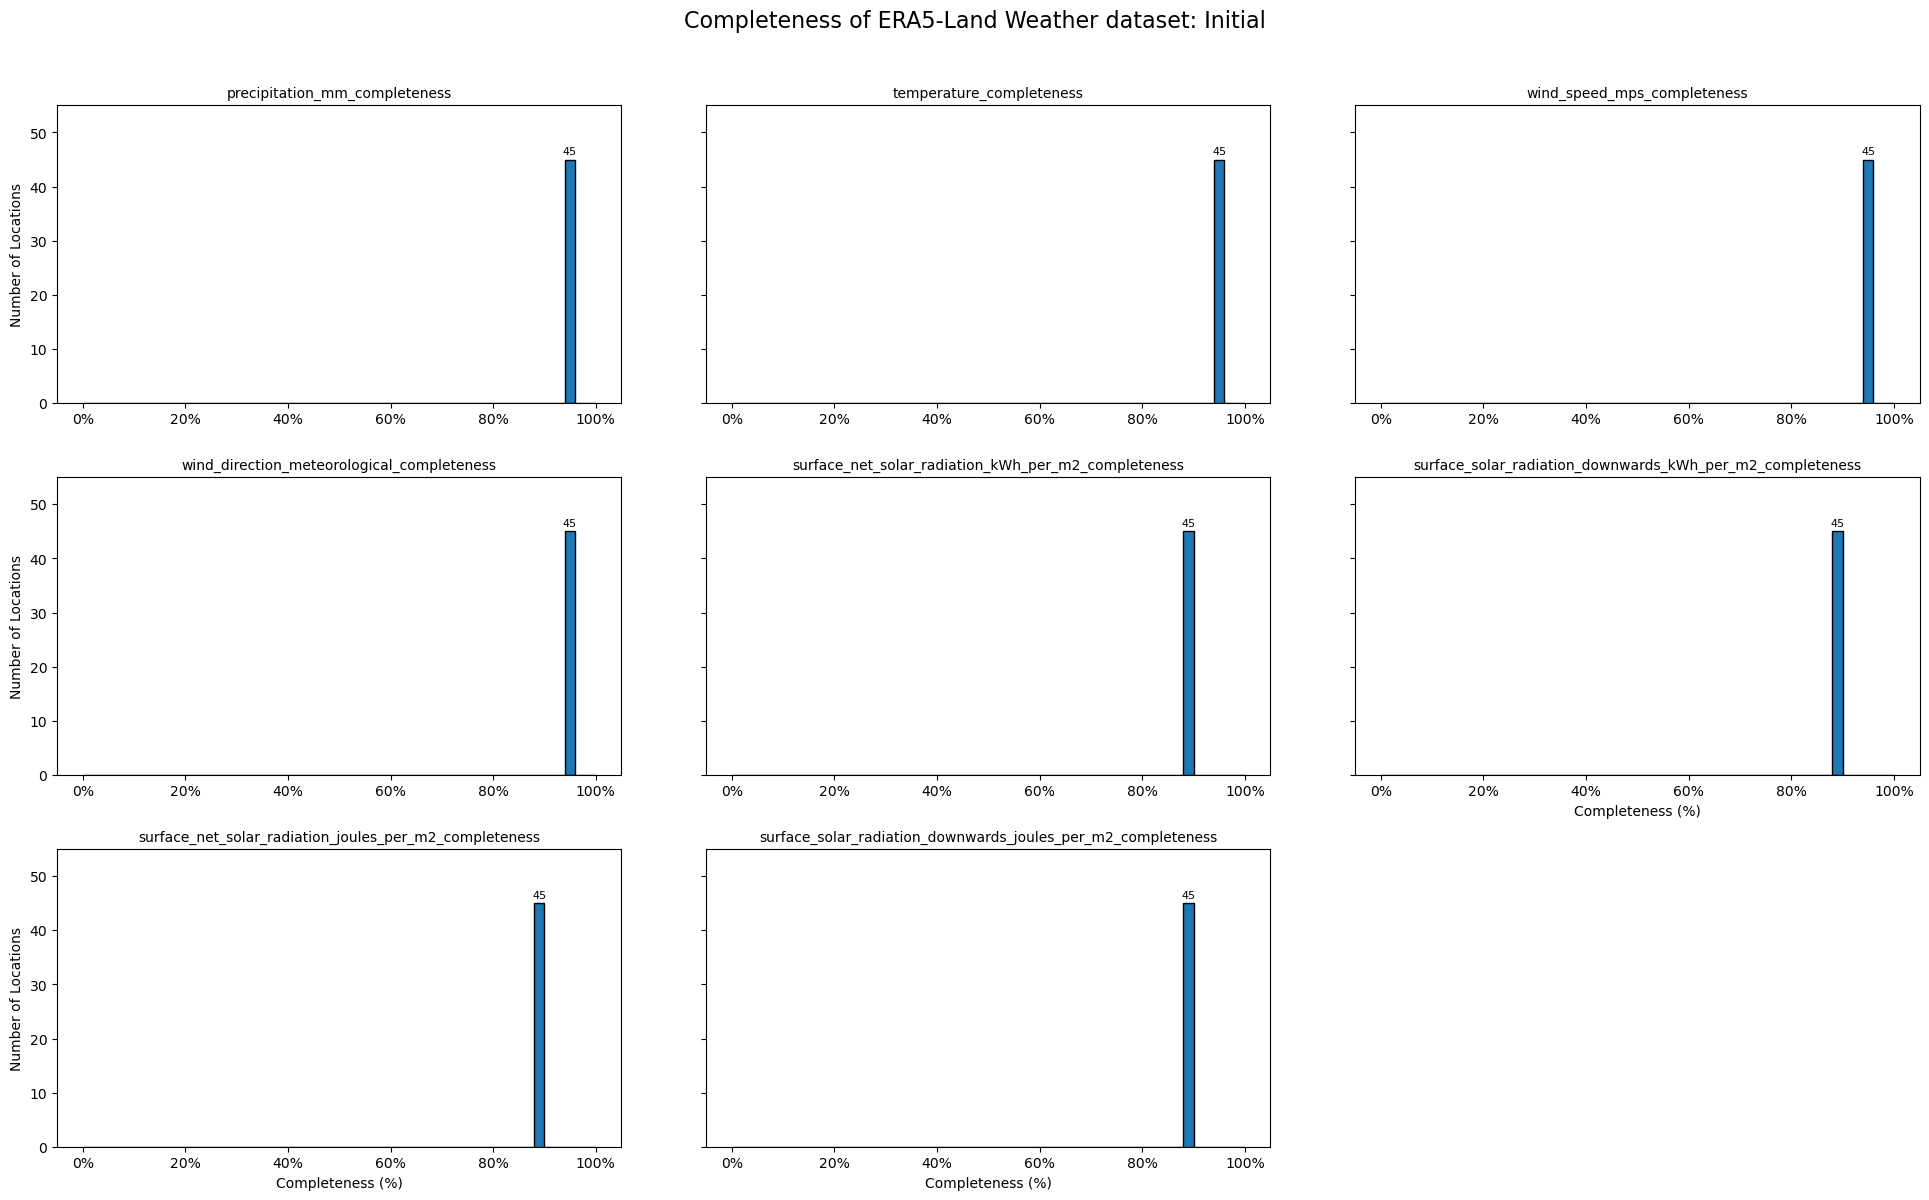

In [41]:
plot_grid = sns.FacetGrid(
    land_plot_df,
    col="column",
    col_wrap=3,
    height=4.0,
    aspect=1.6,
    sharex=True,
    sharey=True,
    despine=False
)

plot_grid.map_dataframe(hist_with_counts)

# Formatting
plot_grid.set_titles("{col_name}")
plot_grid.set_axis_labels("Completeness (%)", "Number of Locations")
for ax in plot_grid.axes.flatten():
    ax.set_xlim(-5, 105)
    ax.set_ylim(0, 55)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(20))
    ax.xaxis.set_major_formatter(mticker.PercentFormatter())
    ax.tick_params(labelbottom=True)

plt.subplots_adjust(top=0.9, hspace=0.25, wspace=0.15)
plot_grid.fig.suptitle("Completeness of ERA5-Land Weather dataset: Initial", fontsize=16)
plt.show()

In [42]:
land_completeness_report.describe()

statistic,land_longitude,land_latitude,total_rows,precipitation_mm_non_null,temperature_non_null,wind_speed_mps_non_null,wind_direction_meteorological_non_null,surface_net_solar_radiation_kWh_per_m2_non_null,surface_solar_radiation_downwards_kWh_per_m2_non_null,surface_net_solar_radiation_joules_per_m2_non_null,surface_solar_radiation_downwards_joules_per_m2_non_null,precipitation_mm_completeness,temperature_completeness,wind_speed_mps_completeness,wind_direction_meteorological_completeness,surface_net_solar_radiation_kWh_per_m2_completeness,surface_solar_radiation_downwards_kWh_per_m2_completeness,surface_net_solar_radiation_joules_per_m2_completeness,surface_solar_radiation_downwards_joules_per_m2_completeness,avg_completeness,min_completeness,max_completeness
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",75.701111,25.393333,47496.0,45473.0,45473.0,45473.0,45473.0,41998.955556,41998.977778,41998.955556,41998.977778,0.957407,0.957407,0.957407,0.957407,0.884263,0.884263,0.884263,0.884263,0.920835,0.884263,0.957407
"""std""",1.991707,4.58988,0.0,0.0,0.0,0.0,0.0,0.208409,0.149071,0.208409,0.149071,1.1228e-16,1.1228e-16,1.1228e-16,1.1228e-16,0.000004,0.000003,0.000004,0.000003,0.000001,0.000005,1.1228e-16
"""min""",72.77,18.5,47496.0,45473.0,45473.0,45473.0,45473.0,41998.0,41998.0,41998.0,41998.0,0.957407,0.957407,0.957407,0.957407,0.884243,0.884243,0.884243,0.884243,0.92083,0.884243,0.957407
"""25%""",72.97,19.2,47496.0,45473.0,45473.0,45473.0,45473.0,41999.0,41999.0,41999.0,41999.0,0.957407,0.957407,0.957407,0.957407,0.884264,0.884264,0.884264,0.884264,0.920835,0.884264,0.957407
"""50%""",76.94,28.5,47496.0,45473.0,45473.0,45473.0,45473.0,41999.0,41999.0,41999.0,41999.0,0.957407,0.957407,0.957407,0.957407,0.884264,0.884264,0.884264,0.884264,0.920835,0.884264,0.957407
"""75%""",77.14,28.7,47496.0,45473.0,45473.0,45473.0,45473.0,41999.0,41999.0,41999.0,41999.0,0.957407,0.957407,0.957407,0.957407,0.884264,0.884264,0.884264,0.884264,0.920835,0.884264,0.957407
"""max""",77.34,28.8,47496.0,45473.0,45473.0,45473.0,45473.0,41999.0,41999.0,41999.0,41999.0,0.957407,0.957407,0.957407,0.957407,0.884264,0.884264,0.884264,0.884264,0.920835,0.884264,0.957407


In [43]:
validate_timestamp_frequency(
    era5_land_weather_pldf_lazy,
    grouping_cols=land_grouping_cols,
    timestamp_col="timestamp",
    expected_freq="1h"
).collect().sort("n_unique_intervals").head(10)

land_longitude,land_latitude,n_unique_intervals,most_common_interval,is_regular
f64,f64,u32,list[i64],bool
77.24,28.7,2,[3600],false
72.77,19.2,2,[3600],false
77.04,28.8,2,[3600],false
76.84,28.6,2,[3600],false
72.97,19.2,2,[3600],false
76.94,28.6,2,[3600],false
76.84,28.5,2,[3600],false
72.97,18.8,2,[3600],false
77.34,28.6,2,[3600],false


In [44]:
get_irregular_intervals(
    era5_land_weather_pldf_lazy.collect(),
    grouping_cols=land_grouping_cols,
    timestamp_col="timestamp"
).sort("time_delta_sec").head(10)

land_longitude,land_latitude,timestamp,time_delta_sec
f64,f64,"datetime[μs, UTC]",i64
72.77,19.2,2019-12-31 01:00:00 UTC,null
72.87,18.8,2019-12-31 01:00:00 UTC,null
72.87,19.0,2019-12-31 01:00:00 UTC,null
72.87,19.1,2019-12-31 01:00:00 UTC,null
72.87,19.2,2019-12-31 01:00:00 UTC,null
72.87,19.3,2019-12-31 01:00:00 UTC,null
72.97,18.5,2019-12-31 01:00:00 UTC,null
72.97,18.6,2019-12-31 01:00:00 UTC,null
72.97,18.7,2019-12-31 01:00:00 UTC,null


#### ERA5 World Data    

In [45]:
era5_world_weather_pldf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature_celsius', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('surface_net_solar_radiation_j_m2', Float64),
        ('surface_solar_radiation_downwards_j_m2', Float64),
        ('surface_net_solar_radiation_kwh', Float64),
        ('surface_solar_radiation_downwards_kwh', Float64),
        ('total_cloud_cover', Float32),
        ('total_precipitation_mm', Float64),
        ('wind_speed', Float32),
        ('wind_direction', Float32),
        ('wind_u_component', Float32),
        ('wind_v_component', Float32)])

In [46]:
world_measurements = [
    "temperature_celsius",
    "high_cloud_cover",
    "medium_cloud_cover",
    "low_cloud_cover",
    "surface_net_solar_radiation_kwh",
    "surface_solar_radiation_downwards_kwh",
    "total_cloud_cover",
    "total_precipitation_mm",
    "wind_speed",
    "wind_direction",
    "wind_u_component",
    "wind_v_component",
]
world_grouping_cols = ["world_longitude", "world_latitude"]

In [47]:
# set streaming chunk size for better performance
pl.Config.set_streaming_chunk_size(65536*2)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# disable logging
pl.Config.set_verbose(False)

# Setup temporary directory for intermediate files
temp_dir = os.path.join(base_data_directory, "temp")

In [50]:
# setup pipeline for processing all files
files = parallelisation_wrapper_null_analysis(
    filepath=era5_world_weather_filepath,
    columns=world_measurements,
    grouping_cols=world_grouping_cols,
    output_dir=temp_dir,
    worker_threads=1
)

final_lazy_df = read_and_join_null_analyses(files, grouping_cols=world_grouping_cols)
result = final_lazy_df.collect(engine="streaming")

# Cleanup temporary directory
cleanup_temp_dir(temp_dir)

[2025-10-24 14:31:35] INFO - Output directory already exists: ../../data/temp
[2025-10-24 14:31:35] INFO - Starting processing of 12 columns...
[2025-10-24 14:31:35] INFO - 
Processing: temperature_celsius
Progress::   0%|          | 0/12 [00:00<?, ?it/s][2025-10-24 14:31:56] INFO - 
Processing: high_cloud_cover
Progress::   8%|▊         | 1/12 [00:20<03:48, 20.74s/it][2025-10-24 14:32:16] INFO - 
Processing: medium_cloud_cover
Progress::  17%|█▋        | 2/12 [00:40<03:22, 20.29s/it][2025-10-24 14:32:35] INFO - 
Processing: low_cloud_cover
Progress::  25%|██▌       | 3/12 [00:59<02:57, 19.67s/it][2025-10-24 14:32:54] INFO - 
Processing: surface_net_solar_radiation_kwh
Progress::  33%|███▎      | 4/12 [01:18<02:35, 19.44s/it][2025-10-24 14:33:15] INFO - 
Processing: surface_solar_radiation_downwards_kwh
Progress::  42%|████▏     | 5/12 [01:39<02:18, 19.74s/it][2025-10-24 14:33:35] INFO - 
Processing: total_cloud_cover
Progress::  50%|█████     | 6/12 [01:59<01:59, 19.86s/it][2025-10-24

In [51]:
result.sample(n=8)

# get all columns in the result DataFrame
all_cols = result.columns

# identify columns that end with _# or _##
columns_to_remove_list = numbered_cols = [col for col in all_cols if re.search(r'_\d+$', col)]

result.drop(columns_to_remove_list)

display(result.drop(columns_to_remove_list).sample(n=8))

world_longitude,world_latitude,temperature_celsius_total_nulls,temperature_celsius_isolated_nulls,temperature_celsius_gaps,high_cloud_cover_total_nulls,high_cloud_cover_isolated_nulls,high_cloud_cover_gaps,medium_cloud_cover_total_nulls,medium_cloud_cover_isolated_nulls,medium_cloud_cover_gaps,low_cloud_cover_total_nulls,low_cloud_cover_isolated_nulls,low_cloud_cover_gaps,surface_net_solar_radiation_kwh_total_nulls,surface_net_solar_radiation_kwh_isolated_nulls,surface_net_solar_radiation_kwh_gaps,surface_solar_radiation_downwards_kwh_total_nulls,surface_solar_radiation_downwards_kwh_isolated_nulls,surface_solar_radiation_downwards_kwh_gaps,total_cloud_cover_total_nulls,total_cloud_cover_isolated_nulls,total_cloud_cover_gaps,total_precipitation_mm_total_nulls,total_precipitation_mm_isolated_nulls,total_precipitation_mm_gaps,wind_speed_total_nulls,wind_speed_isolated_nulls,wind_speed_gaps,wind_direction_total_nulls,wind_direction_isolated_nulls,wind_direction_gaps,wind_u_component_total_nulls,wind_u_component_isolated_nulls,wind_u_component_gaps,wind_v_component_total_nulls,wind_v_component_isolated_nulls,wind_v_component_gaps
f32,f32,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
76.599998,26.9,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
71.099998,19.200001,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
75.5,26.4,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
72.0,18.299999,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
78.699997,29.799999,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
73.099998,20.6,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
75.599998,28.6,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
73.099998,18.200001,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]


In [52]:
world_completeness_report =compute_completeness_lazy(
    era5_world_weather_pldf,
    grouping_col=world_grouping_cols,
    columns_to_check=world_measurements,
)

In [53]:
world_plot_df = completeness_transform_long(
    world_completeness_report,
    grouping_col=world_grouping_cols,
    columns_to_check=world_measurements
)

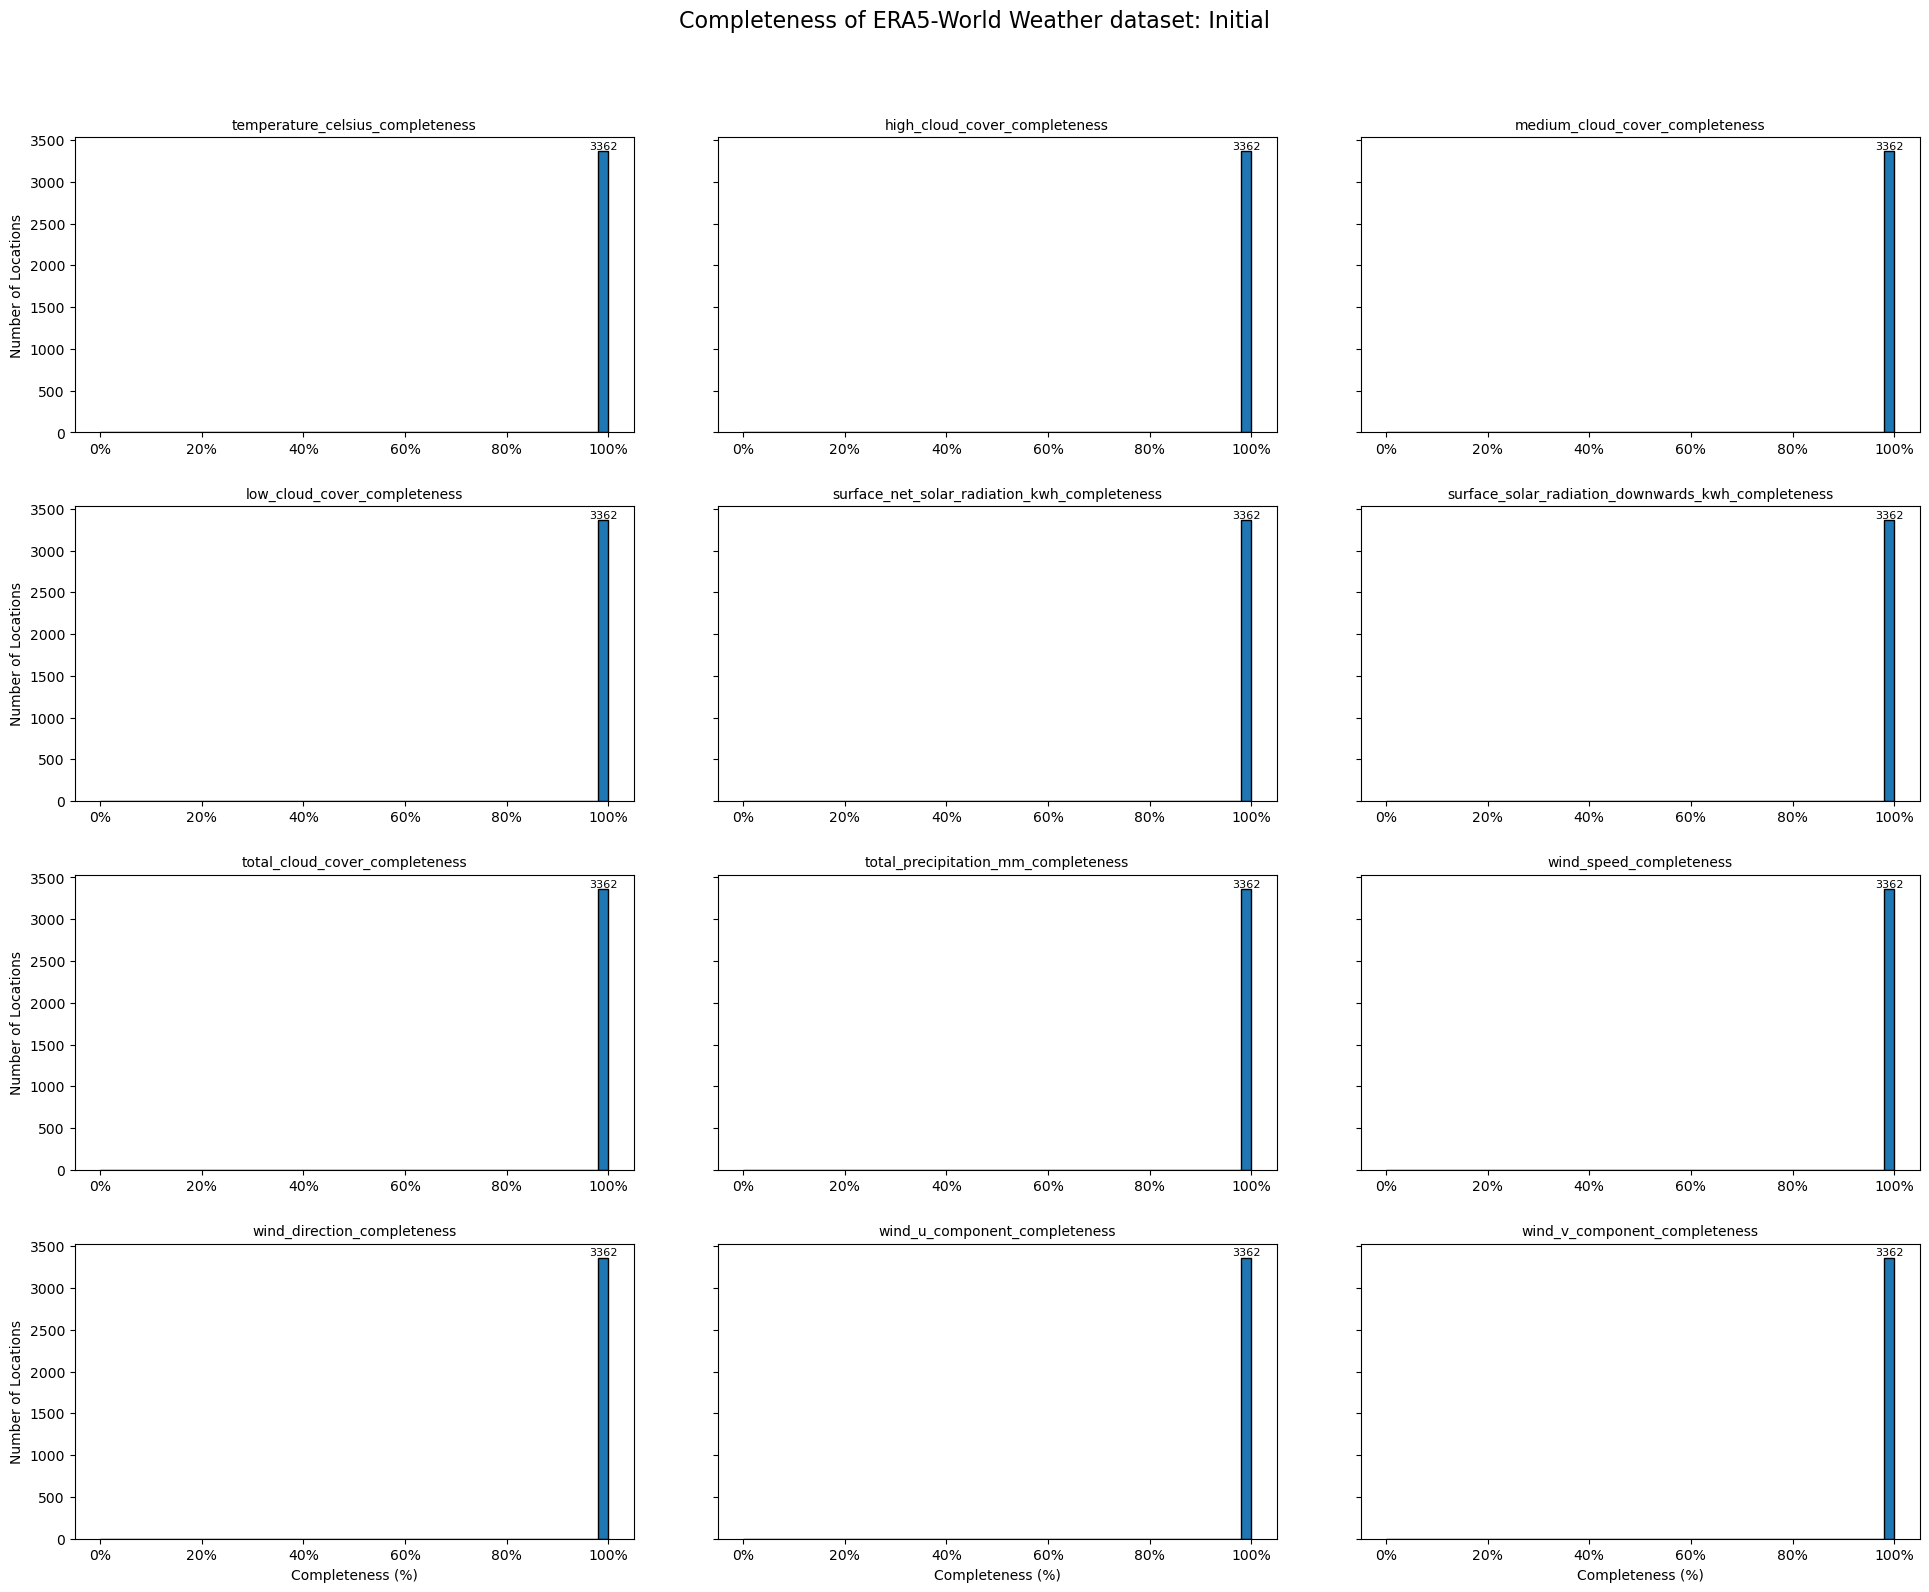

In [54]:
plot_grid = sns.FacetGrid(
    world_plot_df,
    col="column",
    col_wrap=3,
    height=4.0,
    aspect=1.6,
    sharex=True,
    sharey=True,
    despine=False
)

plot_grid.map_dataframe(hist_with_counts)

# Formatting
plot_grid.set_titles("{col_name}")
plot_grid.set_axis_labels("Completeness (%)", "Number of Locations")
for ax in plot_grid.axes.flatten():
    ax.set_xlim(-5, 105)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(20))
    ax.xaxis.set_major_formatter(mticker.PercentFormatter())
    ax.tick_params(labelbottom=True)

plt.subplots_adjust(top=0.9, hspace=0.25, wspace=0.15)
plot_grid.fig.suptitle("Completeness of ERA5-World Weather dataset: Initial", fontsize=16)
plt.show()

### 

### Dropping 2019 Data

In [55]:
# Drop any data from 2019
era5_land_weather_pldf = era5_land_weather_pldf.filter(
    pl.col("timestamp").dt.year() != 2019
)

### Mapping World to Land Locations

#### Data Preparation

In [56]:
# Extract unique locations from the filtered DataFrames
era5_land_data_locations_only = era5_land_weather_pldf.select(["land_longitude", "land_latitude"]).unique()
era5_world_data_locations_only = era5_world_weather_pldf.select(["world_longitude", "world_latitude"]).unique()

In [57]:
# Convert to GeoDataFrames for spatial operations
# And reproject to Web Mercator - Pseudo-Mercato EPSG:3857
# Uses meters as the unit of measurement - good for distance calculations

era5_land_data_locations_only_gdf = gpd.GeoDataFrame(
    era5_land_data_locations_only.to_pandas(),
    geometry=gpd.points_from_xy(
        era5_land_data_locations_only["land_longitude"],
        era5_land_data_locations_only["land_latitude"]
    ),
    crs="EPSG:3857"
)

era5_world_data_locations_only_gdf = gpd.GeoDataFrame(
    era5_world_data_locations_only.to_pandas(),
    geometry=gpd.points_from_xy(
        era5_world_data_locations_only["world_longitude"],
        era5_world_data_locations_only["world_latitude"]
    ),
    crs="EPSG:3857"
)

In [58]:
# now just a quick look at these two GeoDataFrames
print("\n" + "-" * 120)
print("ERA5-Land data locations GeoDataFrame [era5_land_data_locations_only_gdf]:\n" + "-" * 120)
print(f"\tShape : {era5_land_data_locations_only_gdf.shape}")
print("\n" + "-" * 80)
print(f"Sample rows of [era5_land_data_locations_only_gdf]:\n" + "-" * 80)
display(era5_land_data_locations_only_gdf.sample(8))
print("\n" + "-" * 80)
print(f"Descriptive statistics of [era5_land_data_locations_only_gdf]:\n"+ "-" * 80)
display(era5_land_data_locations_only_gdf.describe())


------------------------------------------------------------------------------------------------------------------------
ERA5-Land data locations GeoDataFrame [era5_land_data_locations_only_gdf]:
------------------------------------------------------------------------------------------------------------------------
	Shape : (45, 3)

--------------------------------------------------------------------------------
Sample rows of [era5_land_data_locations_only_gdf]:
--------------------------------------------------------------------------------


,land_longitude,land_latitude,geometry
25,72.87,19.0,POINT (72.87 19)
36,76.84,28.8,POINT (76.84 28.8)
6,77.24,28.7,POINT (77.24 28.7)
28,77.34,28.6,POINT (77.34 28.6)
11,77.34,28.8,POINT (77.34 28.8)
17,77.24,28.8,POINT (77.24 28.8)
13,72.97,18.8,POINT (72.97 18.8)
27,72.77,19.2,POINT (72.77 19.2)



--------------------------------------------------------------------------------
Descriptive statistics of [era5_land_data_locations_only_gdf]:
--------------------------------------------------------------------------------


,land_longitude,land_latitude
count,45.000000,45.000000
mean,75.701111,25.393333
std,1.991707,4.589880
min,72.770000,18.500000
25%,72.970000,19.200000
50%,76.940000,28.500000
75%,77.140000,28.700000
max,77.340000,28.800000


In [59]:
print("\n" + "-" * 120)
print("ERA5-World data locations GeoDataFrame [era5_world_data_locations_only_gdf]:\n" + "-" * 120)
print(f"\tShape : {era5_world_data_locations_only_gdf.shape}")
print("\n" + "-" * 80)
print(f"First few rows of [era5_world_data_locations_only_gdf]:\n" + "-" * 80)
display(era5_world_data_locations_only_gdf.sample(8))
print("\n" + "-" * 80)
print(f"Descriptive statistics of [era5_world_data_locations_only_gdf]:\n"+ "-" * 80)
display(era5_world_data_locations_only_gdf.describe())


------------------------------------------------------------------------------------------------------------------------
ERA5-World data locations GeoDataFrame [era5_world_data_locations_only_gdf]:
------------------------------------------------------------------------------------------------------------------------
	Shape : (3362, 3)

--------------------------------------------------------------------------------
First few rows of [era5_world_data_locations_only_gdf]:
--------------------------------------------------------------------------------


,world_longitude,world_latitude,geometry
1833,73.199997,18.500000,POINT (73.2 18.5)
106,70.400002,18.900000,POINT (70.4 18.9)
1991,70.699997,20.299999,POINT (70.7 20.3)
1962,72.599998,17.400000,POINT (72.6 17.4)
3199,73.500000,18.600000,POINT (73.5 18.6)
1943,71.000000,17.799999,POINT (71 17.8)
967,70.300003,18.799999,POINT (70.3 18.8)
302,78.900002,29.299999,POINT (78.9 29.3)



--------------------------------------------------------------------------------
Descriptive statistics of [era5_world_data_locations_only_gdf]:
--------------------------------------------------------------------------------


,world_longitude,world_latitude
count,3362.000000,3362.000000
mean,74.500000,23.500000
std,2.766275,4.653648
min,70.000000,17.000000
25%,72.000000,19.000000
50%,74.500000,23.500000
75%,77.000000,28.000000
max,79.000000,30.000000


#### Creating Mapping

In [60]:
# mapping the nearest points from the era5 dataset to the weather dataset
gdf_era5_land_with_era5_world_mapped = era5_land_data_locations_only_gdf.sjoin_nearest(
    era5_world_data_locations_only_gdf,
    how="left",
    lsuffix="_land",
    rsuffix="_world",
    distance_col="distance_between_locations_meters",
    max_distance=None,  # Set to None to find all nearest points
)
print("\n" + "-" * 120)
print("ERA5-Land data locations mapped to ERA5-World data locations [gdf_era5_land_with_era5_world_mapped]:\n" + "-" * 120)
print(f"\tShape : {gdf_era5_land_with_era5_world_mapped.shape}")
print(f"\tType : {type(gdf_era5_land_with_era5_world_mapped)}")
print(f"\tColumns : {gdf_era5_land_with_era5_world_mapped.columns.tolist()}")
print("\n" + "-" * 80)
print(f"Sample rows of [gdf_era5_land_with_era5_world_mapped]:\n" + "-" * 80)
display(gdf_era5_land_with_era5_world_mapped.sample(8))
print("\n" + "-" * 80)
print(f"Descriptive statistics of [gdf_era5_land_with_era5_world_mapped]:\n"+ "-" * 80)
display(gdf_era5_land_with_era5_world_mapped.describe())


------------------------------------------------------------------------------------------------------------------------
ERA5-Land data locations mapped to ERA5-World data locations [gdf_era5_land_with_era5_world_mapped]:
------------------------------------------------------------------------------------------------------------------------
	Shape : (45, 7)
	Type : <class 'geopandas.geodataframe.GeoDataFrame'>
	Columns : ['land_longitude', 'land_latitude', 'geometry', 'index__world', 'world_longitude', 'world_latitude', 'distance_between_locations_meters']

--------------------------------------------------------------------------------
Sample rows of [gdf_era5_land_with_era5_world_mapped]:
--------------------------------------------------------------------------------


,land_longitude,land_latitude,geometry,index__world,world_longitude,world_latitude,distance_between_locations_meters
25,72.87,19.0,POINT (72.87 19),445,72.900002,19.000000,0.030002
4,72.87,19.2,POINT (72.87 19.2),3216,72.900002,19.200001,0.030002
40,72.97,18.5,POINT (72.97 18.5),3230,73.000000,18.500000,0.030000
19,77.04,28.7,POINT (77.04 28.7),2042,77.000000,28.700001,0.040000
44,76.84,28.7,POINT (76.84 28.7),1895,76.800003,28.700001,0.039997
21,72.87,19.1,POINT (72.87 19.1),1820,72.900002,19.100000,0.030002
42,76.84,28.5,POINT (76.84 28.5),2571,76.800003,28.500000,0.039997
27,72.77,19.2,POINT (72.77 19.2),885,72.800003,19.200001,0.030003



--------------------------------------------------------------------------------
Descriptive statistics of [gdf_era5_land_with_era5_world_mapped]:
--------------------------------------------------------------------------------


,land_longitude,land_latitude,index__world,world_longitude,world_latitude,distance_between_locations_meters
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,75.701111,25.393333,1780.888889,75.684448,25.393332,0.036667
std,1.991707,4.589880,1015.286283,1.958426,4.589880,0.004767
min,72.770000,18.500000,179.000000,72.800003,18.500000,0.030000
25%,72.970000,19.200000,885.000000,73.000000,19.200001,0.030002
50%,76.940000,28.500000,1895.000000,76.900002,28.500000,0.039997
75%,77.140000,28.700000,2710.000000,77.099998,28.700001,0.040000
max,77.340000,28.800000,3312.000000,77.300003,28.799999,0.040003


In [61]:
# Drop unnecessary columns
# - Noe this converts the GeoDataFrame to a regular pandas DataFrame
gdf_era5_land_with_era5_world_mapped = gdf_era5_land_with_era5_world_mapped.drop(columns=["index__world", "geometry"])


print("-"*120)
print(f"[gdf_era5_land_with_era5_world_mapped] after dropping columns:\n" + "-"*120)
print(f"\tShape : {gdf_era5_land_with_era5_world_mapped.shape}")
print(f"\tType : {type(gdf_era5_land_with_era5_world_mapped)}")
print(f"\tColumns : {gdf_era5_land_with_era5_world_mapped.columns.tolist()}")


------------------------------------------------------------------------------------------------------------------------
[gdf_era5_land_with_era5_world_mapped] after dropping columns:
------------------------------------------------------------------------------------------------------------------------
	Shape : (45, 5)
	Type : <class 'pandas.core.frame.DataFrame'>
	Columns : ['land_longitude', 'land_latitude', 'world_longitude', 'world_latitude', 'distance_between_locations_meters']


In [62]:
# We convert the pandas DataFrame to a Polars DataFrame

# Reset the index of the DataFrame to ensure it is clean
gdf_era5_land_with_era5_world_mapped = gdf_era5_land_with_era5_world_mapped.reset_index(drop=True)
# Convert the pandas DataFrame to a Polars DataFrame
era5_land_with_era5_world_mapped_pldf = pl.from_pandas(gdf_era5_land_with_era5_world_mapped)

print("-"*120)
print(f"[era5_land_with_era5_world_mapped_pldf] after conversion: \n" + "-"*120)
print(f"Shape :\t{era5_land_with_era5_world_mapped_pldf.shape}")
print(f"Type :\t{type(era5_land_with_era5_world_mapped_pldf)}")
print(f"Columns :\t{era5_land_with_era5_world_mapped_pldf.columns}")

print("\n" + "-"*80)
print(f"Sample rows of [era5_land_with_era5_world_mapped_pldf]:\n" + "-"*80)
display(era5_land_with_era5_world_mapped_pldf.head(5))

------------------------------------------------------------------------------------------------------------------------
[era5_land_with_era5_world_mapped_pldf] after conversion: 
------------------------------------------------------------------------------------------------------------------------
Shape :	(45, 5)
Type :	<class 'polars.dataframe.frame.DataFrame'>
Columns :	['land_longitude', 'land_latitude', 'world_longitude', 'world_latitude', 'distance_between_locations_meters']

--------------------------------------------------------------------------------
Sample rows of [era5_land_with_era5_world_mapped_pldf]:
--------------------------------------------------------------------------------


land_longitude,land_latitude,world_longitude,world_latitude,distance_between_locations_meters
f64,f64,f32,f32,f64
77.04,28.5,77.0,28.5,0.04
76.94,28.6,76.900002,28.6,0.039998
76.94,28.8,76.900002,28.799999,0.039998
72.97,18.9,73.0,18.9,0.03
72.87,19.2,72.900002,19.200001,0.030002


#### Adding ERA5 World Coordinates to ERA5 Land Dataset

In [63]:
# Now we add the nearest_era5 points to the weather dataset
era5_land_weather_mapped = era5_land_weather_pldf.join(
    era5_land_with_era5_world_mapped_pldf,
    left_on=["land_longitude", "land_latitude"],
    right_on=["land_longitude", "land_latitude"],
    how="left"
)

print("-" * 120)
print("ERA5-Land Dataset after adding nearest ERA5-World points [era5_land_weather_mapped]:\n" + "-" * 120)
print(f"\tSize : {era5_land_weather_mapped.shape[0]:,} rows")
print(f"\tShape : {era5_land_weather_mapped.shape}")
print("\n" + "-" * 80)
display(era5_land_weather_mapped.schema)

------------------------------------------------------------------------------------------------------------------------
ERA5-Land Dataset after adding nearest ERA5-World points [era5_land_weather_mapped]:
------------------------------------------------------------------------------------------------------------------------
	Size : 2,136,285 rows
	Shape : (2136285, 15)

--------------------------------------------------------------------------------


Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('city', Categorical(ordering='physical')),
        ('precipitation_mm', Float64),
        ('temperature', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('world_longitude', Float32),
        ('world_latitude', Float32),
        ('distance_between_locations_meters', Float64)])

In [64]:
print("\n" + "-" * 120)
print(f"Sample rows of [era5_land_weather_mapped]:\n" + "-" * 120)
display(era5_land_weather_mapped.sample(8))
print("\n" + "-" * 120)
print(f"Descriptive statistics of [era5_land_weather_mapped]:\n" + "-" * 120)
display(era5_land_weather_mapped.describe())


------------------------------------------------------------------------------------------------------------------------
Sample rows of [era5_land_weather_mapped]:
------------------------------------------------------------------------------------------------------------------------


timestamp,land_latitude,land_longitude,city,precipitation_mm,temperature,wind_speed_mps,wind_direction_meteorological,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,world_longitude,world_latitude,distance_between_locations_meters
"datetime[μs, UTC]",f64,f64,cat,f64,f64,f32,f32,f64,f64,f64,f64,f32,f32,f64
2021-12-24 14:00:00 UTC,28.4,77.04,"""delhi""",0.0,16.467834,2.44051,107.225494,3.0874e6,3.7981e6,1.1114544e7,1.3673e7,77.0,28.4,0.04
2025-05-08 00:00:00 UTC,19.3,72.87,"""mumbai""",null,null,null,null,null,null,null,null,72.900002,19.299999,0.030002
2020-11-10 13:00:00 UTC,28.5,77.34,"""delhi""",0.0,22.664612,2.42011,79.856842,3.8021e6,4.5632e6,1.3687609e7,1.6427559e7,77.300003,28.5,0.039997
2021-09-18 17:00:00 UTC,28.5,77.04,"""delhi""",0.080021,26.405182,1.640555,130.802032,3.8343e6,4.8083e6,1.380358e7,1.7309836e7,77.0,28.5,0.04
2024-09-02 04:00:00 UTC,19.3,72.97,"""mumbai""",1.247152,26.01178,1.854127,252.552811,95074.965278,114142.760417,342269.875,410913.9375,73.0,19.299999,0.03
2022-05-11 07:00:00 UTC,28.7,76.84,"""delhi""",0.000997,38.999542,1.305519,141.187012,3.0859e6,3.9284e6,1.1109306e7,1.4142e7,76.800003,28.700001,0.039997
2025-02-10 05:00:00 UTC,18.6,72.97,"""mumbai""",0.0,28.917358,2.378282,2.755524,800640.0,925979.305556,2.882304e6,3.3335e6,73.0,18.6,0.03
2024-05-10 17:00:00 UTC,28.8,77.04,"""delhi""",0.014394,30.137909,2.386496,94.788666,5.8196e6,7.236855e6,2.0950454e7,2.6052678e7,77.0,28.799999,0.04



------------------------------------------------------------------------------------------------------------------------
Descriptive statistics of [era5_land_weather_mapped]:
------------------------------------------------------------------------------------------------------------------------


statistic,timestamp,land_latitude,land_longitude,city,precipitation_mm,temperature,wind_speed_mps,wind_direction_meteorological,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,world_longitude,world_latitude,distance_between_locations_meters
str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2136285""",2.136285e6,2.136285e6,"""2136285""",2.046285e6,2.046285e6,2.046285e6,2.046285e6,1.889953e6,1.889954e6,1.889953e6,1.889954e6,2.136285e6,2.136285e6,2.136285e6
"""null_count""","""0""",0.0,0.0,"""0""",90000.0,90000.0,90000.0,90000.0,246332.0,246331.0,246332.0,246331.0,0.0,0.0,0.0
"""mean""","""2022-09-16 00:00:00+00:00""",25.393333,75.701111,null,1.737392,25.379801,2.643632,210.427979,3.1322e6,3.7606e6,1.1276e7,1.3538e7,75.684448,25.393333,0.036667
"""std""",null,4.538596,1.969453,null,6.866434,6.977661,1.397325,108.77739,1.9246e6,2.3062e6,6.9285e6,8.3022e6,1.936544,4.538596,0.004713
"""min""","""2020-01-01 00:00:00+00:00""",18.5,72.77,null,0.0,0.487457,0.002416,0.0,0.0,0.0,0.0,0.0,72.800003,18.5,0.03
"""25%""","""2021-05-09 12:00:00+00:00""",19.2,72.97,null,0.0,21.677216,1.694546,109.567871,1.4062e6,1671542.5,5.062334e6,6.017553e6,73.0,19.200001,0.030002
"""50%""","""2022-09-16 00:00:00+00:00""",28.5,76.94,null,0.001287,26.418579,2.428091,245.46402,3.4204e6,4.1284e6,1.2313436e7,1.4862e7,76.900002,28.5,0.039997
"""75%""","""2024-01-23 12:00:00+00:00""",28.7,77.14,null,0.466184,29.746643,3.333483,305.416016,4.6302e6,5.5312e6,1.6668687e7,1.9912196e7,77.099998,28.700001,0.04
"""max""","""2025-06-01 00:00:00+00:00""",28.8,77.34,null,314.004838,46.374786,19.006941,359.999786,6.9232e6,8.0662e6,2.4923e7,2.9038414e7,77.300003,28.799999,0.040003


In [65]:
era5_land_weather_mapped.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('city', Categorical(ordering='physical')),
        ('precipitation_mm', Float64),
        ('temperature', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('world_longitude', Float32),
        ('world_latitude', Float32),
        ('distance_between_locations_meters', Float64)])

In [66]:
# Reordering Columns for readability
era5_land_weather_mapped = era5_land_weather_mapped.select(
    "timestamp", "city", "land_latitude", "land_longitude", "world_latitude", "world_longitude",
    "temperature", "precipitation_mm", "wind_speed_mps", "wind_direction_meteorological",
    "surface_net_solar_radiation_kWh_per_m2", "surface_solar_radiation_downwards_kWh_per_m2",
    "surface_net_solar_radiation_joules_per_m2", "surface_solar_radiation_downwards_joules_per_m2",
    "distance_between_locations_meters",
)
display(era5_land_weather_mapped.head(5))

timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,temperature,precipitation_mm,wind_speed_mps,wind_direction_meteorological,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,distance_between_locations_meters
"datetime[μs, UTC]",cat,f64,f64,f32,f32,f64,f64,f32,f32,f64,f64,f64,f64,f64
2024-12-13 13:00:00 UTC,"""delhi""",28.4,77.34,28.4,77.300003,15.97522,0.0,3.582388,285.092316,3.4157e6,4.1463e6,1.2296608e7,1.4926616e7,0.039997
2024-12-13 14:00:00 UTC,"""delhi""",28.8,76.84,28.799999,76.800003,14.646027,0.0,3.705909,290.726135,3.3634e6,4.0933e6,1.2108108e7,1.473605e7,0.039997
2024-12-13 14:00:00 UTC,"""delhi""",28.8,76.94,28.799999,76.900002,14.629242,0.0,3.726924,290.277252,3.3749e6,4.0938e6,1.2149601e7,1.4737817e7,0.039998
2024-12-13 14:00:00 UTC,"""delhi""",28.8,77.04,28.799999,77.0,14.623779,0.0,3.756802,289.706665,3.4002e6,4.0941e6,1.2240716e7,1.4738703e7,0.04
2024-12-13 14:00:00 UTC,"""delhi""",28.8,77.14,28.799999,77.099998,14.611298,0.0,3.779561,289.043518,3.4106e6,4.0945e6,1.2278334e7,1.4740205e7,0.040002


In [67]:
# Saving coordinates files
era5_land_weather_coordinates_filepath = era5_land_weather_filepath.replace(".parquet", "_coordinates.parquet")

try:
    era5_land_weather_mapped.write_parquet(
    era5_land_weather_coordinates_filepath,
    compression="snappy",
    statistics=True,)
    temp_files.append(era5_land_weather_coordinates_filepath)
    print(f"Wrote [era5_land_weather_mapped] to parquet: {era5_land_weather_coordinates_filepath}")
except Exception as e:
    print(f"Failed to write [era5_land_weather_mapped] to parquet: {e}")
    raise

Wrote [era5_land_weather_mapped] to parquet: ../../data/hitachi/weather_20250714_1401_processed_coordinates.parquet


### Gap Filling

In [68]:
# Setup helper lists

# Cumulative measurement columns (land)
cumulative_measurement_cols = [
    "precipitation_mm",
    "surface_net_solar_radiation_kWh_per_m2",
    "surface_solar_radiation_downwards_kWh_per_m2",
    "surface_net_solar_radiation_joules_per_m2",
    "surface_solar_radiation_downwards_joules_per_m2",
]

# Instantaneous measurement columns (land)
instantaneous_measurement_cols = [
    "temperature",
    "wind_speed_mps",
    "wind_direction_meteorological"
]

# Land to world mapping for gap filling
land_to_world_field_mapping = {
    "temperature": "temperature_celsius",
    "precipitation_mm": "total_precipitation_mm",
    "wind_speed_mps": "wind_speed",
    "wind_direction_meteorological": "wind_direction",
    "surface_net_solar_radiation_kWh_per_m2": "surface_net_solar_radiation_kwh",
    "surface_solar_radiation_downwards_kWh_per_m2": "surface_solar_radiation_downwards_kwh",
    "surface_net_solar_radiation_joules_per_m2": "surface_net_solar_radiation_j_m2",
    "surface_solar_radiation_downwards_joules_per_m2": "surface_solar_radiation_downwards_j_m2",
}

In [69]:
era5_land_weather_pldf_lazy = pl.scan_parquet(era5_land_weather_coordinates_filepath)
era5_world_weather_pldf_lazy =era5_world_weather_pldf.lazy()

print("-"*80)
print(f"[era5_land_weather_pldf_lazy] type : {type(era5_land_weather_pldf)}")
print("-"*80)
print(f"[era5_world_weather_pldf_lazy] type : {type(era5_world_weather_pldf_lazy)}")


--------------------------------------------------------------------------------
[era5_land_weather_pldf_lazy] type : <class 'polars.dataframe.frame.DataFrame'>
--------------------------------------------------------------------------------
[era5_world_weather_pldf_lazy] type : <class 'polars.lazyframe.frame.LazyFrame'>


#### Filling Midnight Gaps

In [70]:
midnights_filled = fill_midnight_pass(
    land_lf=era5_land_weather_pldf_lazy,
    world_lf=era5_world_weather_pldf_lazy,
    land_columns_to_fill=land_measurements,
    land_to_world_field_map=land_to_world_field_mapping,
    audit_col="processing_operations",
    overwrite_non_null=False,
    land_grouping_cols=land_grouping_cols,
    land_world_key_cols=["world_longitude", "world_latitude"],
    world_grouping_cols=["world_longitude", "world_latitude"],
    target_hour=0,
)

In [71]:
midnights_filled_pldf = midnights_filled.collect()

In [72]:
midnights_filled_pldf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature', Float64),
        ('precipitation_mm', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('distance_between_locations_meters', Float64),
        ('processing_operations',
         List(Struct({'column': String, 'method': String})))])

In [73]:
midnights_filled_pldf.describe()

statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,temperature,precipitation_mm,wind_speed_mps,wind_direction_meteorological,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,distance_between_locations_meters,processing_operations
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2136285""","""2136285""",2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.13525e6,2.13525e6,2.13525e6,2.13525e6,1.978963e6,1.978964e6,1.978963e6,1.978964e6,2.136285e6,2.136285e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,1035.0,1035.0,1035.0,1035.0,157322.0,157321.0,157322.0,157321.0,0.0,0.0
"""mean""","""2022-09-16 00:00:00+00:00""",null,25.393333,75.701111,25.393333,75.684448,25.25055,1.670894,2.628988,209.547302,2.9914e6,3.5914e6,1.0769e7,1.2929e7,0.036667,null
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,6.99889,6.730469,1.391385,108.893761,1.9897e6,2.3847e6,7.1628e6,8.5848e6,0.004713,null
"""min""","""2020-01-01 00:00:00+00:00""",null,18.5,72.77,18.5,72.800003,0.487457,0.0,0.002416,0.0,0.0,0.0,0.0,0.0,0.03,null
"""25%""","""2021-05-09 12:00:00+00:00""",null,19.2,72.97,19.200001,73.0,21.506744,0.0,1.686554,108.616791,1.0465e6,1.2653e6,3.767532e6,4554901.5,0.030002,null
"""50%""","""2022-09-16 00:00:00+00:00""",null,28.5,76.94,28.5,76.900002,26.360657,0.001162,2.409993,244.152649,3.3191e6,4.0103e6,1.1948852e7,1.4437184e7,0.039997,null
"""75%""","""2024-01-23 12:00:00+00:00""",null,28.7,77.14,28.700001,77.099998,29.614227,0.415002,3.312154,304.953827,4.5665e6,5.4600e6,1.643946e7,1.9655914e7,0.04,null
"""max""","""2025-06-01 00:00:00+00:00""",null,28.8,77.34,28.799999,77.300003,46.374786,314.004838,19.006941,359.999786,6.9232e6,8.0662e6,2.4923e7,2.9038414e7,0.040003,null


##### Rechecking Null Profiles

In [74]:
midnights_measurements = [
    "temperature",
    "precipitation_mm",
    "wind_speed_mps",
    "wind_direction_meteorological",
    "surface_net_solar_radiation_kWh_per_m2",
    "surface_solar_radiation_downwards_kWh_per_m2",
    "surface_net_solar_radiation_joules_per_m2",
    "surface_solar_radiation_downwards_joules_per_m2",
]

In [75]:
# Checking Profile of Null Values Midnight Filling

# build a list of DataFrames, one per variable
second_land_null_stats_df = [
    analyze_null_patterns(midnights_filled_pldf, col, grouping_cols=land_grouping_cols)
    for col in midnights_measurements
]

In [76]:

# reduce‑join them all together
second_land_null_stats_2_df = reduce(
    lambda left, right: left.join(
        right.select(land_grouping_cols + [c for c in right.collect_schema().names() if c not in land_grouping_cols]),
        on=land_grouping_cols,
        how="left"
    ),
    second_land_null_stats_df
).fill_null(0)

In [77]:
gap_cols = [f"{c}_gaps" for c in land_measurements]

second_land_null_stats_3_df = second_land_null_stats_2_df.with_columns([
    # this sorts each List<Struct{gap_start, gap_end}> by gap_start (then gap_end if equal)
    pl.col(g).list.sort().alias(g)
    for g in gap_cols
])

display(second_land_null_stats_3_df.sample(n=8, with_replacement=False))

land_longitude,land_latitude,temperature_total_nulls,temperature_isolated_nulls,temperature_gaps,precipitation_mm_total_nulls,precipitation_mm_isolated_nulls,precipitation_mm_gaps,wind_speed_mps_total_nulls,wind_speed_mps_isolated_nulls,wind_speed_mps_gaps,wind_direction_meteorological_total_nulls,wind_direction_meteorological_isolated_nulls,wind_direction_meteorological_gaps,surface_net_solar_radiation_kWh_per_m2_total_nulls,surface_net_solar_radiation_kWh_per_m2_isolated_nulls,surface_net_solar_radiation_kWh_per_m2_gaps,surface_solar_radiation_downwards_kWh_per_m2_total_nulls,surface_solar_radiation_downwards_kWh_per_m2_isolated_nulls,surface_solar_radiation_downwards_kWh_per_m2_gaps,surface_net_solar_radiation_joules_per_m2_total_nulls,surface_net_solar_radiation_joules_per_m2_isolated_nulls,surface_net_solar_radiation_joules_per_m2_gaps,surface_solar_radiation_downwards_joules_per_m2_total_nulls,surface_solar_radiation_downwards_joules_per_m2_isolated_nulls,surface_solar_radiation_downwards_joules_per_m2_gaps
f64,f64,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
77.34,28.4,23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]"
72.97,19.3,23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]"
77.34,28.8,23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]"
72.87,19.0,23,0,"[{2022-10-31 01:00:00 UTC,2022-10

##### Saving Processed Data

In [78]:
# Saving coordinates files
era5_land_midnight_filled_filepath = era5_land_weather_filepath.replace(".parquet", "_midnight_filled.parquet")

try:
    midnights_filled_pldf.write_parquet(
    era5_land_midnight_filled_filepath,
    compression="snappy",
    statistics=True,)
    temp_files.append(era5_land_midnight_filled_filepath)
    print(f"Wrote [era5_land_weather_mapped] to parquet: {era5_land_midnight_filled_filepath}")
except Exception as e:
    print(f"Failed to write [midnights_filled] to parquet: {e}")
    raise

Wrote [era5_land_weather_mapped] to parquet: ../../data/hitachi/weather_20250714_1401_processed_midnight_filled.parquet


#### Filling Instantaneous Fields Consecutive Gaps

In [79]:
# loading the updated data
era5_land_midnight_filled_pldf = pl.scan_parquet(era5_land_midnight_filled_filepath)

# remember the era5_world_weather is [era5_world_weather_pldf_lazy]

In [80]:
land_cols  = set(era5_land_midnight_filled_pldf.collect_schema().names())
world_cols = set(era5_world_weather_pldf_lazy.collect_schema().names())

# filter land_to_world_field_mapping to only include columns that exist in instantaneous_measurement_cols
land_to_world_field_mapping_instant = {
    k: v
    for k, v in land_to_world_field_mapping.items()
    if k in instantaneous_measurement_cols
    and k in land_cols
    and v in world_cols
}
land_to_world_field_mapping_instant

{'temperature': 'temperature_celsius',
 'wind_speed_mps': 'wind_speed',
 'wind_direction_meteorological': 'wind_direction'}

In [81]:
consecutive_gaps_lazy = impute_consecutive_gaps_lazy(
    land_lf=era5_land_midnight_filled_pldf.lazy(),
    world_lf=era5_world_weather_pldf_lazy,
    mapping=land_to_world_field_mapping_instant,
    audit_col="processing_operations",
    min_gap={"days": 0, "hours": 1, "minutes": 0, "seconds": 0},
    land_grouping_cols=land_grouping_cols,
    land_world_key_cols=["world_longitude", "world_latitude"],
    world_grouping_cols=["world_longitude", "world_latitude"],
    land_timestamp_col="timestamp",
    world_timestamp_col="timestamp",
    align_world_keys_to_float32=True
)


In [82]:
consecutive_gaps = consecutive_gaps_lazy.collect()

In [83]:
consecutive_gaps.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature', Float64),
        ('precipitation_mm', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('distance_between_locations_meters', Float64),
        ('processing_operations',
         List(Struct({'column': String, 'method': String})))])

In [84]:
consecutive_gaps.describe( )

statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,temperature,precipitation_mm,wind_speed_mps,wind_direction_meteorological,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,distance_between_locations_meters,processing_operations
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2136285""","""2136285""",2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.13525e6,2.136285e6,2.136285e6,1.978963e6,1.978964e6,1.978963e6,1.978964e6,2.136285e6,2.136285e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,1035.0,0.0,0.0,157322.0,157321.0,157322.0,157321.0,0.0,0.0
"""mean""","""2022-09-16 00:00:00+00:00""",null,25.393333,75.701111,25.393333,75.684448,25.250025,1.670894,2.628679,209.5345,2.9914e6,3.5914e6,1.0769e7,1.2929e7,0.036667,null
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,6.997929,6.730469,1.391219,108.896484,1.9897e6,2.3847e6,7.1628e6,8.5848e6,0.004713,null
"""min""","""2020-01-01 00:00:00+00:00""",null,18.5,72.77,18.5,72.800003,0.487457,0.0,0.002416,0.0,0.0,0.0,0.0,0.0,0.03,null
"""25%""","""2021-05-09 12:00:00+00:00""",null,19.2,72.97,19.200001,73.0,21.504852,0.0,1.686474,108.602478,1.0465e6,1.2653e6,3.767532e6,4554901.5,0.030002,null
"""50%""","""2022-09-16 00:00:00+00:00""",null,28.5,76.94,28.5,76.900002,26.360077,0.001162,2.409616,244.12677,3.3191e6,4.0103e6,1.1948852e7,1.4437184e7,0.039997,null
"""75%""","""2024-01-23 12:00:00+00:00""",null,28.7,77.14,28.700001,77.099998,29.613251,0.415002,3.311706,304.953156,4.5665e6,5.4600e6,1.643946e7,1.9655914e7,0.04,null
"""max""","""2025-06-01 00:00:00+00:00""",null,28.8,77.34,28.799999,77.300003,46.374786,314.004838,19.006941,359.999786,6.9232e6,8.0662e6,2.4923e7,2.9038414e7,0.040003,null


In [85]:
# build a list of DataFrames, one per variable
third_land_null_stats_df = [
    analyze_null_patterns(consecutive_gaps, col, grouping_cols=land_grouping_cols)
    for col in land_measurements
]

# reduce‑join them all together
third_land_null_stats_2_df = reduce(
    lambda left, right: left.join(
        right.select(land_grouping_cols + [c for c in right.columns if c not in land_grouping_cols]),
        on=land_grouping_cols,
        how="left"
    ),
    third_land_null_stats_df
).fill_null(0)

gap_cols = [f"{c}_gaps" for c in land_measurements]

third_land_null_stats_3_df = third_land_null_stats_2_df.with_columns([
    # this sorts each List<Struct{gap_start, gap_end}> by gap_start (then gap_end if equal)
    pl.col(g).list.sort().alias(g)
    for g in gap_cols
])

display(third_land_null_stats_3_df.sample(n=8, with_replacement=False))

land_longitude,land_latitude,precipitation_mm_total_nulls,precipitation_mm_isolated_nulls,precipitation_mm_gaps,temperature_total_nulls,temperature_isolated_nulls,temperature_gaps,wind_speed_mps_total_nulls,wind_speed_mps_isolated_nulls,wind_speed_mps_gaps,wind_direction_meteorological_total_nulls,wind_direction_meteorological_isolated_nulls,wind_direction_meteorological_gaps,surface_net_solar_radiation_kWh_per_m2_total_nulls,surface_net_solar_radiation_kWh_per_m2_isolated_nulls,surface_net_solar_radiation_kWh_per_m2_gaps,surface_solar_radiation_downwards_kWh_per_m2_total_nulls,surface_solar_radiation_downwards_kWh_per_m2_isolated_nulls,surface_solar_radiation_downwards_kWh_per_m2_gaps,surface_net_solar_radiation_joules_per_m2_total_nulls,surface_net_solar_radiation_joules_per_m2_isolated_nulls,surface_net_solar_radiation_joules_per_m2_gaps,surface_solar_radiation_downwards_joules_per_m2_total_nulls,surface_solar_radiation_downwards_joules_per_m2_isolated_nulls,surface_solar_radiation_downwards_joules_per_m2_gaps
f64,f64,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
76.94,28.6,23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",0,0,[],0,0,[],0,0,[],3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]"
76.94,28.4,23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",0,0,[],0,0,[],0,0,[],3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]"
76.84,28.7,23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",0,0,[],0,0,[],0,0,[],3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]"
77.34,28.8,23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",0,0,[],0,0,[],0,0,[],3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 2

In [86]:
# Saving coordinates files
era5_land_instant_consec_filled_filepath = era5_land_weather_filepath.replace(".parquet", "_instant_consec_filled.parquet")

try:
    consecutive_gaps.write_parquet(
    era5_land_instant_consec_filled_filepath,
    compression="snappy",
    statistics=True,)
    temp_files.append(era5_land_instant_consec_filled_filepath)
    print(f"Wrote [era5_land_weather_mapped] to parquet: {era5_land_instant_consec_filled_filepath}")
except Exception as e:
    print(f"Failed to write [era5_land_instant_consec_filled_filepath] to parquet: {e}")
    raise

Wrote [era5_land_weather_mapped] to parquet: ../../data/hitachi/weather_20250714_1401_processed_instant_consec_filled.parquet


### Resolving Cumulative Measurements

#### Deaccumulating Cumulative Fields

In [87]:
land_cols  = set(era5_land_midnight_filled_pldf.collect_schema().names())
world_cols = set(era5_world_weather_pldf_lazy.collect_schema().names())

# filter land_to_world_field_mapping to only include columns that exist in instantaneous_measurement_cols
land_to_world_field_mapping_cumulative = {
    k: v
    for k, v in land_to_world_field_mapping.items()
    if k in cumulative_measurement_cols
    and k in land_cols
    and v in world_cols
}
land_to_world_field_mapping_cumulative

{'precipitation_mm': 'total_precipitation_mm',
 'surface_net_solar_radiation_kWh_per_m2': 'surface_net_solar_radiation_kwh',
 'surface_solar_radiation_downwards_kWh_per_m2': 'surface_solar_radiation_downwards_kwh',
 'surface_net_solar_radiation_joules_per_m2': 'surface_net_solar_radiation_j_m2',
 'surface_solar_radiation_downwards_joules_per_m2': 'surface_solar_radiation_downwards_j_m2'}

In [88]:
deacc_lf = deaccumulate_land_data_lazy(
    consecutive_gaps,  # LazyFrame
    accum_vars=land_to_world_field_mapping_cumulative,   # or pass your list
    timestamp_col="timestamp",
    location_cols=["land_longitude", "land_latitude"],
    start_hour=2,
    audit_col="processing_operations",
)


In [89]:
deacc_lf.describe()

statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,temperature,precipitation_mm,wind_speed_mps,wind_direction_meteorological,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,distance_between_locations_meters,processing_operations,deacc_precipitation_mm,deacc_surface_net_solar_radiation_kWh_per_m2,deacc_surface_solar_radiation_downwards_kWh_per_m2,deacc_surface_net_solar_radiation_joules_per_m2,deacc_surface_solar_radiation_downwards_joules_per_m2
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2136285""","""2136285""",2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.13525e6,2.136285e6,2.136285e6,1.978963e6,1.978964e6,1.978963e6,1.978964e6,2.136285e6,2.136285e6,1.95723e6,1.807738e6,1.807738e6,1.807738e6,1.807738e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,1035.0,0.0,0.0,157322.0,157321.0,157322.0,157321.0,0.0,0.0,179055.0,328547.0,328547.0,328547.0,328547.0
"""mean""","""2022-09-16 00:00:00+00:00""",null,25.393333,75.701111,25.393333,75.684448,25.250025,1.670894,2.628679,209.5345,2.9914e6,3.5914e6,1.0769e7,1.2929e7,0.036667,null,0.147839,197793.728494,237379.267778,712057.422577,854565.363999
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,6.997929,6.730469,1.391219,108.896484,1.9897e6,2.3847e6,7.1628e6,8.5848e6,0.004713,null,0.669518,249791.526423,299027.914139,899249.495122,1.0765e6
"""min""","""2020-01-01 00:00:00+00:00""",null,18.5,72.77,18.5,72.800003,0.487457,0.0,0.002416,0.0,0.0,0.0,0.0,0.0,0.03,null,0.0,0.0,0.0,0.0,0.0
"""25%""","""2021-05-09 12:00:00+00:00""",null,19.2,72.97,19.200001,73.0,21.504852,0.0,1.686474,108.602478,1.0465e6,1.2653e6,3.767532e6,4554901.5,0.030002,null,0.0,0.0,0.0,0.0,0.0
"""50%""","""2022-09-16 00:00:00+00:00""",null,28.5,76.94,28.5,76.900002,26.360077,0.001162,2.409616,244.12677,3.3191e6,4.0103e6,1.1948852e7,1.4437184e7,0.039997,null,0.0,38774.722222,46336.388889,139589.0,166811.0
"""75%""","""2024-01-23 12:00:00+00:00""",null,28.7,77.14,28.700001,77.099998,29.613251,0.415002,3.311706,304.953156,4.5665e6,5.4600e6,1.643946e7,1.9655914e7,0.04,null,0.005759,394382.621528,476551.527778,1.4198e6,1715585.5
"""max""","""2025-06-01 00:00:00+00:00""",null,28.8,77.34,28.799999,77.300003,46.374786,314.004838,19.006941,359.999786,6.9232e6,8.0662e6,2.4923e7,2.9038414e7,0.040003,null,32.492071,925827.777778,1.0256e6,3.33298e6,3.6921e6


In [90]:
deacc_lf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature', Float64),
        ('precipitation_mm', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('distance_between_locations_meters', Float64),
        ('processing_operations',
         List(Struct({'column': String, 'method': String}))),
        ('deacc_precipitation_mm', Float64),
        ('deacc_surface_net_solar_radiation_kWh_per_m2', Float64),
        ('deacc_surface_solar_radiation_downwa

In [91]:
check_cols = [
    "precipitation_mm",
    "temperature",
    "wind_speed_mps",
    "wind_direction_meteorological",
    "surface_net_solar_radiation_kWh_per_m2",
    "surface_solar_radiation_downwards_kWh_per_m2",
    "surface_net_solar_radiation_joules_per_m2",
    "surface_solar_radiation_downwards_joules_per_m2",
    "deacc_precipitation_mm",
    "deacc_surface_net_solar_radiation_kWh_per_m2",
    "deacc_surface_solar_radiation_downwards_kWh_per_m2",
    "deacc_surface_net_solar_radiation_joules_per_m2",
    "deacc_surface_solar_radiation_downwards_joules_per_m2"
]


In [92]:
# build a list of DataFrames, one per variable
fourth_land_null_stats_df = [
    analyze_null_patterns(deacc_lf, col, grouping_cols=land_grouping_cols)
    for col in check_cols
]

# reduce‑join them all together
fourth_land_null_stats_2_df = reduce(
    lambda left, right: left.join(
        right.select(land_grouping_cols + [c for c in right.columns if c not in land_grouping_cols]),
        on=land_grouping_cols,
        how="left"
    ),
    fourth_land_null_stats_df
).fill_null(0)

gap_cols = [f"{c}_gaps" for c in check_cols]

fourth_land_null_stats_3_df = fourth_land_null_stats_2_df.with_columns([
    # this sorts each List<Struct{gap_start, gap_end}> by gap_start (then gap_end if equal)
    pl.col(g).list.sort().alias(g)
    for g in gap_cols
])

display(fourth_land_null_stats_3_df.sample(n=8, with_replacement=False))

land_longitude,land_latitude,precipitation_mm_total_nulls,precipitation_mm_isolated_nulls,precipitation_mm_gaps,temperature_total_nulls,temperature_isolated_nulls,temperature_gaps,wind_speed_mps_total_nulls,wind_speed_mps_isolated_nulls,wind_speed_mps_gaps,wind_direction_meteorological_total_nulls,wind_direction_meteorological_isolated_nulls,wind_direction_meteorological_gaps,surface_net_solar_radiation_kWh_per_m2_total_nulls,surface_net_solar_radiation_kWh_per_m2_isolated_nulls,surface_net_solar_radiation_kWh_per_m2_gaps,surface_solar_radiation_downwards_kWh_per_m2_total_nulls,surface_solar_radiation_downwards_kWh_per_m2_isolated_nulls,surface_solar_radiation_downwards_kWh_per_m2_gaps,surface_net_solar_radiation_joules_per_m2_total_nulls,surface_net_solar_radiation_joules_per_m2_isolated_nulls,surface_net_solar_radiation_joules_per_m2_gaps,surface_solar_radiation_downwards_joules_per_m2_total_nulls,surface_solar_radiation_downwards_joules_per_m2_isolated_nulls,surface_solar_radiation_downwards_joules_per_m2_gaps,deacc_precipitation_mm_total_nulls,deacc_precipitation_mm_isolated_nulls,deacc_precipitation_mm_gaps,deacc_surface_net_solar_radiation_kWh_per_m2_total_nulls,deacc_surface_net_solar_radiation_kWh_per_m2_isolated_nulls,deacc_surface_net_solar_radiation_kWh_per_m2_gaps,deacc_surface_solar_radiation_downwards_kWh_per_m2_total_nulls,deacc_surface_solar_radiation_downwards_kWh_per_m2_isolated_nulls,deacc_surface_solar_radiation_downwards_kWh_per_m2_gaps,deacc_surface_net_solar_radiation_joules_per_m2_total_nulls,deacc_surface_net_solar_radiation_joules_per_m2_isolated_nulls,deacc_surface_net_solar_radiation_joules_per_m2_gaps,deacc_surface_solar_radiation_downwards_joules_per_m2_total_nulls,deacc_surface_solar_radiation_downwards_joules_per_m2_isolated_nulls,deacc_surface_solar_radiation_downwards_joules_per_m2_gaps
f64,f64,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
77.14,28.7,23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",0,0,[],0,0,[],0,0,[],3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3979,0,"[{2022-10-31 00:00:00 UTC,2022-11-01 01:00:00 UTC}]",7301,0,"[{2022-10-31 00:00:00 UTC,2023-04-01 01:00:00 UTC}]",7301,0,"[{2022-10-31 00:00:00 UTC,2023-04-01 01:00:00 UTC}]",7301,0,"[{2022-10-31 00:00:00 UTC,2023-04-01 01:00:00 UTC}]",7301,0,"[{2022-10-31 00:00:00 UTC,2023-04-01 01:00:00 UTC}]"
72.97,19.2,23,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}]",0,0,[],0,0,[],0,0,[],3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3496,0,"[{2022-10-31 01:00:00 UTC,2022-10-31 23:00:00 UTC}, {2022-11-01 01:00:00 UTC,2022-11-01 23:00:00 UTC}, … {2023-03-31 01:00:00 UTC,2023-03-31 23:00:00 UTC}]",3979,0,"[{2022-10-31 

#### Creating Interval Columns

In [93]:
vars = list(land_to_world_field_mapping_cumulative.keys())
print(f"Variables used for deaccumulation: {vars}")

Variables used for deaccumulation: ['precipitation_mm', 'surface_net_solar_radiation_kWh_per_m2', 'surface_solar_radiation_downwards_kWh_per_m2', 'surface_net_solar_radiation_joules_per_m2', 'surface_solar_radiation_downwards_joules_per_m2']


In [94]:
interval_lf = create_interval_columns_lazy(
    deacc_lf,
    accum_vars=vars,
    timestamp_col="timestamp",
    location_cols=["land_longitude", "land_latitude"],
    start_hour=2
)

In [95]:
interval_lf.describe()

statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,temperature,precipitation_mm,wind_speed_mps,wind_direction_meteorological,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,distance_between_locations_meters,processing_operations,deacc_precipitation_mm,deacc_surface_net_solar_radiation_kWh_per_m2,deacc_surface_solar_radiation_downwards_kWh_per_m2,deacc_surface_net_solar_radiation_joules_per_m2,deacc_surface_solar_radiation_downwards_joules_per_m2,interval_precipitation_mm,interval_surface_net_solar_radiation_kWh_per_m2,interval_surface_solar_radiation_downwards_kWh_per_m2,interval_surface_net_solar_radiation_joules_per_m2,interval_surface_solar_radiation_downwards_joules_per_m2
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2136285""","""2136285""",2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.13525e6,2.136285e6,2.136285e6,1.978963e6,1.978964e6,1.978963e6,1.978964e6,2.136285e6,2.136285e6,1.95723e6,1.807738e6,1.807738e6,1.807738e6,1.807738e6,2.13525e6,1.978962e6,1.978963e6,1.978962e6,1.978963e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,1035.0,0.0,0.0,157322.0,157321.0,157322.0,157321.0,0.0,0.0,179055.0,328547.0,328547.0,328547.0,328547.0,1035.0,157323.0,157322.0,157323.0,157322.0
"""mean""","""2022-09-16 00:00:00+00:00""",null,25.393333,75.701111,25.393333,75.684448,25.250025,1.670894,2.628679,209.5345,2.9914e6,3.5914e6,1.0769e7,1.2929e7,0.036667,null,0.147839,197793.728494,237379.267778,712057.422577,854565.363999,0.147308,181046.909124,217290.324053,651769.100262,782245.457793
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,6.997929,6.730469,1.391219,108.896484,1.9897e6,2.3847e6,7.1628e6,8.5848e6,0.004713,null,0.669518,249791.526423,299027.914139,899249.495122,1.0765e6,0.662956,245417.97384,293780.125417,883504.538084,1.0576e6
"""min""","""2020-01-01 00:00:00+00:00""",null,18.5,72.77,18.5,72.800003,0.487457,0.0,0.002416,0.0,0.0,0.0,0.0,0.0,0.03,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""","""2021-05-09 12:00:00+00:00""",null,19.2,72.97,19.200001,73.0,21.504852,0.0,1.686474,108.602478,1.0465e6,1.2653e6,3.767532e6,4554901.5,0.030002,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""50%""","""2022-09-16 00:00:00+00:00""",null,28.5,76.94,28.5,76.900002,26.360077,0.001162,2.409616,244.12677,3.3191e6,4.0103e6,1.1948852e7,1.4437184e7,0.039997,null,0.0,38774.722222,46336.388889,139589.0,166811.0,0.0,8345.555556,9966.56901,30044.0,35879.648438
"""75%""","""2024-01-23 12:00:00+00:00""",null,28.7,77.14,28.700001,77.099998,29.613251,0.415002,3.311706,304.953156,4.5665e6,5.4600e6,1.643946e7,1.9655914e7,0.04,null,0.005759,394382.621528,476551.527778,1.4198e6,1715585.5,0.005392,355484.010417,430610.833333,1.2797e6,1.550199e6
"""max""","""2025-06-01 00:00:00+00:00""",null,28.8,77.34,28.799999,77.300003,46.374786,314.004838,19.006941,359.999786,6.9232e6,8.0662e6,2.4923e7,2.9038414e7,0.040003,null,32.492071,925827.777778,1.0256e6,3.33298e6,3.6921e6,32.492071,4.6355e6,5.0640e6,1.6688e7,1.8230394e7


In [96]:
# Saving coordinates files
era5_land_interval_filepath = era5_land_weather_filepath.replace(".parquet", "_interval.parquet")

try:
    interval_lf.write_parquet(
    era5_land_interval_filepath,
    compression="snappy",
    statistics=True,)
    temp_files.append(era5_land_interval_filepath)
    print(f"Wrote [interval_lf] to parquet: {era5_land_interval_filepath}")
except Exception as e:
    print(f"Failed to write [interval_lf] to parquet: {e}")
    raise

Wrote [interval_lf] to parquet: ../../data/hitachi/weather_20250714_1401_processed_interval.parquet


#### Filling Final Gaps

In [97]:
interval_lf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature', Float64),
        ('precipitation_mm', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('distance_between_locations_meters', Float64),
        ('processing_operations',
         List(Struct({'column': String, 'method': String}))),
        ('deacc_precipitation_mm', Float64),
        ('deacc_surface_net_solar_radiation_kWh_per_m2', Float64),
        ('deacc_surface_solar_radiation_downwa

In [98]:
reduced_interval_lf = interval_lf.drop([
    "precipitation_mm",
    "surface_net_solar_radiation_kWh_per_m2",
    "surface_solar_radiation_downwards_kWh_per_m2",
    "surface_net_solar_radiation_joules_per_m2",
    "surface_solar_radiation_downwards_joules_per_m2",
    "deacc_precipitation_mm",
    "deacc_surface_net_solar_radiation_kWh_per_m2",
    "deacc_surface_solar_radiation_downwards_kWh_per_m2",
    "deacc_surface_net_solar_radiation_joules_per_m2",
    "deacc_surface_solar_radiation_downwards_joules_per_m2"
    ])


In [99]:
reduced_interval_lf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('distance_between_locations_meters', Float64),
        ('processing_operations',
         List(Struct({'column': String, 'method': String}))),
        ('interval_precipitation_mm', Float64),
        ('interval_surface_net_solar_radiation_kWh_per_m2', Float64),
        ('interval_surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('interval_surface_net_solar_radiation_joules_per_m2', Float64),
        ('interval_surface_solar_radiation_downwards_joules_per_m2', Float64)])

In [100]:
era5_world_weather_pldf.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature_celsius', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('surface_net_solar_radiation_j_m2', Float64),
        ('surface_solar_radiation_downwards_j_m2', Float64),
        ('surface_net_solar_radiation_kwh', Float64),
        ('surface_solar_radiation_downwards_kwh', Float64),
        ('total_cloud_cover', Float32),
        ('total_precipitation_mm', Float64),
        ('wind_speed', Float32),
        ('wind_direction', Float32),
        ('wind_u_component', Float32),
        ('wind_v_component', Float32)])

In [101]:
era5_world_weather_pldf_reduced = era5_world_weather_pldf.drop([
    "high_cloud_cover",
    "medium_cloud_cover",
    "low_cloud_cover",
    "total_cloud_cover",
    "wind_u_component",
    "wind_v_component",
    "temperature_celsius",
    "wind_speed",
    "wind_direction"
])

In [102]:
filling_mapping = {
    "interval_precipitation_mm" : "total_precipitation_mm",
    "interval_surface_net_solar_radiation_kWh_per_m2" : "surface_net_solar_radiation_kwh",
    "interval_surface_solar_radiation_downwards_kWh_per_m2" : "surface_solar_radiation_downwards_kwh",
    "interval_surface_net_solar_radiation_joules_per_m2" : "surface_net_solar_radiation_j_m2",
    "interval_surface_solar_radiation_downwards_joules_per_m2": "surface_solar_radiation_downwards_j_m2"
    }

In [103]:
print(f"Type of [reduced_interval_lf] {type(reduced_interval_lf)}")
print(f"Type of [era5_world_weather_pldf] {type(era5_world_weather_pldf)}")
print(f"Type of [era5_world_weather_pldf_lazy] {type(era5_world_weather_pldf_lazy)}")


Type of [reduced_interval_lf] <class 'polars.dataframe.frame.DataFrame'>
Type of [era5_world_weather_pldf] <class 'polars.dataframe.frame.DataFrame'>
Type of [era5_world_weather_pldf_lazy] <class 'polars.lazyframe.frame.LazyFrame'>


In [104]:
filled_intervals = fill_interval_from_world_lazy(
    land_lf=reduced_interval_lf.lazy(),            # the LF with your interval_* columns
    world_lf=era5_world_weather_pldf_reduced.lazy(),  # the LF with your world_* columns
    interval_to_world=filling_mapping,
    audit_col="processing_operations",             # or "final_fill" if you want a new audit stream
    overwrite_non_null=False,            # only fill true gaps
    land_timestamp_col="timestamp",
    world_timestamp_col="timestamp",
    land_world_key_cols=["world_longitude", "world_latitude"],
    world_grouping_cols=["world_longitude", "world_latitude"],
    dedupe_world=True,                   # ensure m:1 on WORLD side
    align_world_keys_to_float32=True,
    only_rows_with_nulls=True,          # only fill rows with nulls in the land LF
)

In [105]:
filled_intervals_df = filled_intervals.collect()

In [106]:
era5_land_filled_filepath = era5_land_weather_filepath.replace(".parquet", "_filled.parquet")

try:
    filled_intervals_df.write_parquet(
            era5_land_filled_filepath,
            compression="snappy",
            statistics=True,)
    temp_files.append(era5_land_filled_filepath)
    print(f"Wrote [era5_land_weather_mapped] to parquet: {era5_land_filled_filepath}")

except Exception as e:
    print(f"Failed to write [midnights_filled] to parquet: {e}")
    raise

Wrote [era5_land_weather_mapped] to parquet: ../../data/hitachi/weather_20250714_1401_processed_filled.parquet


In [107]:
filled_intervals_df.describe(  )

statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,temperature,wind_speed_mps,wind_direction_meteorological,distance_between_locations_meters,processing_operations,interval_precipitation_mm,interval_surface_net_solar_radiation_kWh_per_m2,interval_surface_solar_radiation_downwards_kWh_per_m2,interval_surface_net_solar_radiation_joules_per_m2,interval_surface_solar_radiation_downwards_joules_per_m2
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2136285""","""2136285""",2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-09-16 00:00:00+00:00""",null,25.393333,75.701111,25.393333,75.684448,25.250025,2.628679,209.5345,0.036667,null,0.147236,167714.037176,201288.472687,651854.203699,780782.51073
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,6.997929,1.391219,108.896484,0.004713,null,0.662803,240895.321183,288395.343582,883274.199351,1.0548e6
"""min""","""2020-01-01 00:00:00+00:00""",null,18.5,72.77,18.5,72.800003,0.487457,0.002416,0.0,0.03,null,0.0,0.0,0.0,0.0,0.0
"""25%""","""2021-05-09 12:00:00+00:00""",null,19.2,72.97,19.200001,73.0,21.504852,1.686474,108.602478,0.030002,null,0.0,0.0,0.0,0.0,0.0
"""50%""","""2022-09-16 00:00:00+00:00""",null,28.5,76.94,28.5,76.900002,26.360077,2.409616,244.12677,0.039997,null,0.0,40.916693,48.458337,28248.0,33644.0
"""75%""","""2024-01-23 12:00:00+00:00""",null,28.7,77.14,28.700001,77.099998,29.613251,3.311706,304.953156,0.04,null,0.005361,323421.111111,387725.78125,1.283709e6,1.552676e6
"""max""","""2025-06-01 00:00:00+00:00""",null,28.8,77.34,28.799999,77.300003,46.374786,19.006941,359.999786,0.040003,null,32.492071,4.6355e6,5.0640e6,1.6688e7,1.8230394e7


In [108]:
filled_intervals_df.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('distance_between_locations_meters', Float64),
        ('processing_operations',
         List(Struct({'column': String, 'method': String}))),
        ('interval_precipitation_mm', Float64),
        ('interval_surface_net_solar_radiation_kWh_per_m2', Float64),
        ('interval_surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('interval_surface_net_solar_radiation_joules_per_m2', Float64),
        ('interval_surface_solar_radiation_downwards_joules_per_m2', Float64)])

In [109]:
cols_to_check = [
    "wind_direction_meteorological",
    "wind_speed_mps",
    "temperature",
    "interval_precipitation_mm",
    "interval_surface_net_solar_radiation_kWh_per_m2",
    "interval_surface_solar_radiation_downwards_kWh_per_m2",
    "interval_surface_net_solar_radiation_joules_per_m2",
    "interval_surface_solar_radiation_downwards_joules_per_m2",
]

In [110]:
# Checking Profile of Null Values post imputation

# build a list of DataFrames, one per variable
fifth_land_null_stats_df = [
    analyze_null_patterns(filled_intervals_df, col, grouping_cols=land_grouping_cols)
    for col in cols_to_check
]

# reduce‑join them all together
fifth_land_null_stats_2_df = reduce(
    lambda left, right: left.join(
        right.select(land_grouping_cols + [c for c in right.columns if c not in land_grouping_cols]),
        on=land_grouping_cols,
        how="left"
    ),
    fifth_land_null_stats_df
).fill_null(0)

gap_cols = [f"{c}_gaps" for c in cols_to_check]

fifth_land_null_stats_3_df = fifth_land_null_stats_2_df.with_columns([
    # this sorts each List<Struct{gap_start, gap_end}> by gap_start (then gap_end if equal)
    pl.col(g).list.sort().alias(g)
    for g in gap_cols
])

display(fifth_land_null_stats_3_df.sample(n=8, with_replacement=False))

land_longitude,land_latitude,wind_direction_meteorological_total_nulls,wind_direction_meteorological_isolated_nulls,wind_direction_meteorological_gaps,wind_speed_mps_total_nulls,wind_speed_mps_isolated_nulls,wind_speed_mps_gaps,temperature_total_nulls,temperature_isolated_nulls,temperature_gaps,interval_precipitation_mm_total_nulls,interval_precipitation_mm_isolated_nulls,interval_precipitation_mm_gaps,interval_surface_net_solar_radiation_kWh_per_m2_total_nulls,interval_surface_net_solar_radiation_kWh_per_m2_isolated_nulls,interval_surface_net_solar_radiation_kWh_per_m2_gaps,interval_surface_solar_radiation_downwards_kWh_per_m2_total_nulls,interval_surface_solar_radiation_downwards_kWh_per_m2_isolated_nulls,interval_surface_solar_radiation_downwards_kWh_per_m2_gaps,interval_surface_net_solar_radiation_joules_per_m2_total_nulls,interval_surface_net_solar_radiation_joules_per_m2_isolated_nulls,interval_surface_net_solar_radiation_joules_per_m2_gaps,interval_surface_solar_radiation_downwards_joules_per_m2_total_nulls,interval_surface_solar_radiation_downwards_joules_per_m2_isolated_nulls,interval_surface_solar_radiation_downwards_joules_per_m2_gaps
f64,f64,u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]],u32,u32,list[struct[2]]
72.87,19.1,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
77.14,28.5,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
77.24,28.5,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
76.84,28.8,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
72.97,18.5,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
77.34,28.8,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
72.87,19.2,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]
76.84,28.4,0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[],0,0,[]


#### Bringing In ERA5-World Data

In [111]:
print(f"Columns in [filled_intervals_df] ERA5-LAND: {filled_intervals_df.columns}")
print(f"Columns in [era5_world_weather_pldf] ERA5-WORLD: {era5_world_weather_pldf.columns}")

Columns in [filled_intervals_df] ERA5-LAND: ['timestamp', 'city', 'land_latitude', 'land_longitude', 'world_latitude', 'world_longitude', 'temperature', 'wind_speed_mps', 'wind_direction_meteorological', 'distance_between_locations_meters', 'processing_operations', 'interval_precipitation_mm', 'interval_surface_net_solar_radiation_kWh_per_m2', 'interval_surface_solar_radiation_downwards_kWh_per_m2', 'interval_surface_net_solar_radiation_joules_per_m2', 'interval_surface_solar_radiation_downwards_joules_per_m2']
Columns in [era5_world_weather_pldf] ERA5-WORLD: ['timestamp', 'world_latitude', 'world_longitude', 'temperature_celsius', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover', 'surface_net_solar_radiation_j_m2', 'surface_solar_radiation_downwards_j_m2', 'surface_net_solar_radiation_kwh', 'surface_solar_radiation_downwards_kwh', 'total_cloud_cover', 'total_precipitation_mm', 'wind_speed', 'wind_direction', 'wind_u_component', 'wind_v_component']


In [112]:
join_columns = ["timestamp", "world_latitude", "world_longitude"]
target_columns = ["total_cloud_cover", "high_cloud_cover", "medium_cloud_cover", "low_cloud_cover"]

filled_intervals_joined = filled_intervals.join(
                        era5_world_weather_pldf_lazy.select(join_columns + target_columns),
                        on=join_columns,
                        how="left"
        )

In [113]:
filled_intervals_joined_df = filled_intervals_joined.collect()

In [114]:
filled_intervals_joined_df.describe()

statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,temperature,wind_speed_mps,wind_direction_meteorological,distance_between_locations_meters,processing_operations,interval_precipitation_mm,interval_surface_net_solar_radiation_kWh_per_m2,interval_surface_solar_radiation_downwards_kWh_per_m2,interval_surface_net_solar_radiation_joules_per_m2,interval_surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2136285""","""2136285""",2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-09-16 00:00:00+00:00""",null,25.393333,75.701111,25.393333,75.684448,25.250025,2.628679,209.5345,0.036667,null,0.147236,167714.037176,201288.472687,651854.203699,780782.51073,0.358229,0.261578,0.152169,0.108004
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,6.997929,1.391219,108.896484,0.004713,null,0.662803,240895.321183,288395.343582,883274.199351,1.0548e6,0.392378,0.381675,0.246474,0.225071
"""min""","""2020-01-01 00:00:00+00:00""",null,18.5,72.77,18.5,72.800003,0.487457,0.002416,0.0,0.03,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""","""2021-05-09 12:00:00+00:00""",null,19.2,72.97,19.200001,73.0,21.504852,1.686474,108.602478,0.030002,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""50%""","""2022-09-16 00:00:00+00:00""",null,28.5,76.94,28.5,76.900002,26.360077,2.409616,244.12677,0.039997,null,0.0,40.916693,48.458337,28248.0,33644.0,0.17215,0.0,0.019104,0.0
"""75%""","""2024-01-23 12:00:00+00:00""",null,28.7,77.14,28.700001,77.099998,29.613251,3.311706,304.953156,0.04,null,0.005361,323421.111111,387725.78125,1.283709e6,1.552676e6,0.773621,0.537598,0.211365,0.089996
"""max""","""2025-06-01 00:00:00+00:00""",null,28.8,77.34,28.799999,77.300003,46.374786,19.006941,359.999786,0.040003,null,32.492071,4.6355e6,5.0640e6,1.6688e7,1.8230394e7,1.0,1.0,1.0,1.0


In [115]:
filled_intervals_joined_df.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('temperature', Float64),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('distance_between_locations_meters', Float64),
        ('processing_operations',
         List(Struct({'column': String, 'method': String}))),
        ('interval_precipitation_mm', Float64),
        ('interval_surface_net_solar_radiation_kWh_per_m2', Float64),
        ('interval_surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('interval_surface_net_solar_radiation_joules_per_m2', Float64),
        ('interval_surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Flo

In [116]:
# reoganizee and rename columns for clarity
filled_intervals_joined_df = filled_intervals_joined_df.select([
    pl.col("timestamp"),
    pl.col("city"),
    pl.col("land_latitude"),
    pl.col("land_longitude"),
    pl.col("world_latitude"),
    pl.col("world_longitude"),
    pl.col("wind_speed_mps"),
    pl.col("wind_direction_meteorological"),
    pl.col("temperature").alias("temperature_celsius"),
    pl.col("interval_precipitation_mm").alias("precipitation_mm"),
    pl.col("interval_surface_net_solar_radiation_kWh_per_m2").alias("surface_net_solar_radiation_kWh_per_m2"),
    pl.col("interval_surface_solar_radiation_downwards_kWh_per_m2").alias("surface_solar_radiation_downwards_kWh_per_m2"),
    pl.col("interval_surface_net_solar_radiation_joules_per_m2").alias("surface_net_solar_radiation_joules_per_m2"),
    pl.col("interval_surface_solar_radiation_downwards_joules_per_m2").alias("surface_solar_radiation_downwards_joules_per_m2"),
    pl.col("total_cloud_cover"),
    pl.col("high_cloud_cover"),
    pl.col("medium_cloud_cover"),
    pl.col("low_cloud_cover"),
    pl.col("distance_between_locations_meters").alias("distance_between_locations_meters"),
    pl.col("processing_operations").alias("processing_operations_log"),
])


In [117]:
filled_intervals_joined_df.schema

Schema([('timestamp', Datetime(time_unit='us', time_zone='UTC')),
        ('city', Categorical(ordering='physical')),
        ('land_latitude', Float64),
        ('land_longitude', Float64),
        ('world_latitude', Float32),
        ('world_longitude', Float32),
        ('wind_speed_mps', Float32),
        ('wind_direction_meteorological', Float32),
        ('temperature_celsius', Float64),
        ('precipitation_mm', Float64),
        ('surface_net_solar_radiation_kWh_per_m2', Float64),
        ('surface_solar_radiation_downwards_kWh_per_m2', Float64),
        ('surface_net_solar_radiation_joules_per_m2', Float64),
        ('surface_solar_radiation_downwards_joules_per_m2', Float64),
        ('total_cloud_cover', Float32),
        ('high_cloud_cover', Float32),
        ('medium_cloud_cover', Float32),
        ('low_cloud_cover', Float32),
        ('distance_between_locations_meters', Float64),
        ('processing_operations_log',
         List(Struct({'column': String, 'method': 

In [118]:
filled_intervals_joined_df.describe()

statistic,timestamp,city,land_latitude,land_longitude,world_latitude,world_longitude,wind_speed_mps,wind_direction_meteorological,temperature_celsius,precipitation_mm,surface_net_solar_radiation_kWh_per_m2,surface_solar_radiation_downwards_kWh_per_m2,surface_net_solar_radiation_joules_per_m2,surface_solar_radiation_downwards_joules_per_m2,total_cloud_cover,high_cloud_cover,medium_cloud_cover,low_cloud_cover,distance_between_locations_meters,processing_operations_log
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2136285""","""2136285""",2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6,2.136285e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-09-16 00:00:00+00:00""",null,25.393333,75.701111,25.393333,75.684448,2.628679,209.5345,25.250025,0.147236,167714.037176,201288.472687,651854.203699,780782.51073,0.358229,0.261578,0.152169,0.108004,0.036667,null
"""std""",null,null,4.538596,1.969453,4.538596,1.936544,1.391219,108.896484,6.997929,0.662803,240895.321183,288395.343582,883274.199351,1.0548e6,0.392378,0.381675,0.246474,0.225071,0.004713,null
"""min""","""2020-01-01 00:00:00+00:00""",null,18.5,72.77,18.5,72.800003,0.002416,0.0,0.487457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,null
"""25%""","""2021-05-09 12:00:00+00:00""",null,19.2,72.97,19.200001,73.0,1.686474,108.602478,21.504852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030002,null
"""50%""","""2022-09-16 00:00:00+00:00""",null,28.5,76.94,28.5,76.900002,2.409616,244.12677,26.360077,0.0,40.916693,48.458337,28248.0,33644.0,0.17215,0.0,0.019104,0.0,0.039997,null
"""75%""","""2024-01-23 12:00:00+00:00""",null,28.7,77.14,28.700001,77.099998,3.311706,304.953156,29.613251,0.005361,323421.111111,387725.78125,1.283709e6,1.552676e6,0.773621,0.537598,0.211365,0.089996,0.04,null
"""max""","""2025-06-01 00:00:00+00:00""",null,28.8,77.34,28.799999,77.300003,19.006941,359.999786,46.374786,32.492071,4.6355e6,5.0640e6,1.6688e7,1.8230394e7,1.0,1.0,1.0,1.0,0.040003,null


In [119]:
# Extract Date and Time
era5_land_weather_filename_base = os.path.basename(era5_land_weather_filepath)
pattern = r"(\d{8})_(\d{4})"  # 8 digits, underscore, 4 digits
match = re.search(pattern, era5_land_weather_filename_base)


output_filepath = os.path.join(hitachi_data_directory,f"weather_data_combined_{match.group(1)}_{match.group(2)}.parquet")

In [120]:
try:
    filled_intervals_joined_df.write_parquet(
            output_filepath,
            compression="snappy",
            statistics=True,)
    print(f"Wrote [filled_intervals_joined_df] to parquet: {output_filepath}")

except Exception as e:
    print(f"Failed to write [filled_intervals_joined_df] to parquet: {e}")
    raise

Wrote [filled_intervals_joined_df] to parquet: ../../data/hitachi/weather_data_combined_20250714_1401.parquet


### Cleanup

In [121]:
# Remove the temporary files created during processing
for filepath in temp_files:
    try:
        os.remove(filepath)
        print(f"Temporary file {filepath} removed successfully.")
    except Exception as e:
        print(f"Error removing temporary file {filepath}: {e}")
print("\n" + "-" * 120)
print("Processing complete. All temporary files removed.")

Temporary file ../../data/hitachi/weather_20250714_1401_processed_coordinates.parquet removed successfully.
Temporary file ../../data/hitachi/weather_20250714_1401_processed_midnight_filled.parquet removed successfully.
Temporary file ../../data/hitachi/weather_20250714_1401_processed_instant_consec_filled.parquet removed successfully.
Temporary file ../../data/hitachi/weather_20250714_1401_processed_interval.parquet removed successfully.
Temporary file ../../data/hitachi/weather_20250714_1401_processed_filled.parquet removed successfully.

------------------------------------------------------------------------------------------------------------------------
Processing complete. All temporary files removed.


### Visualisation

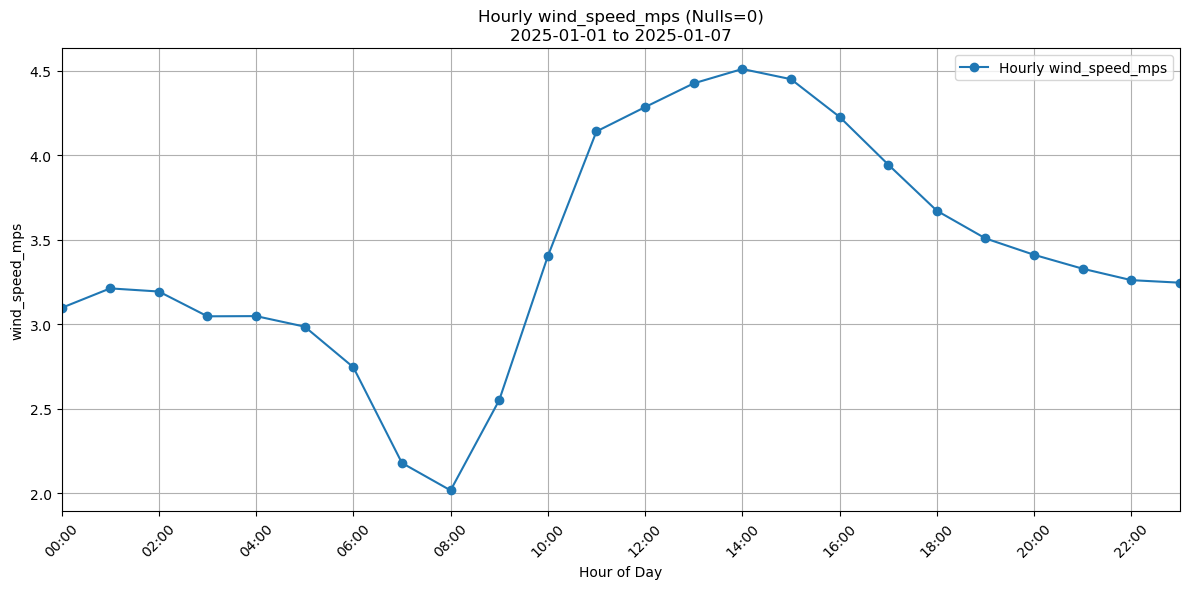

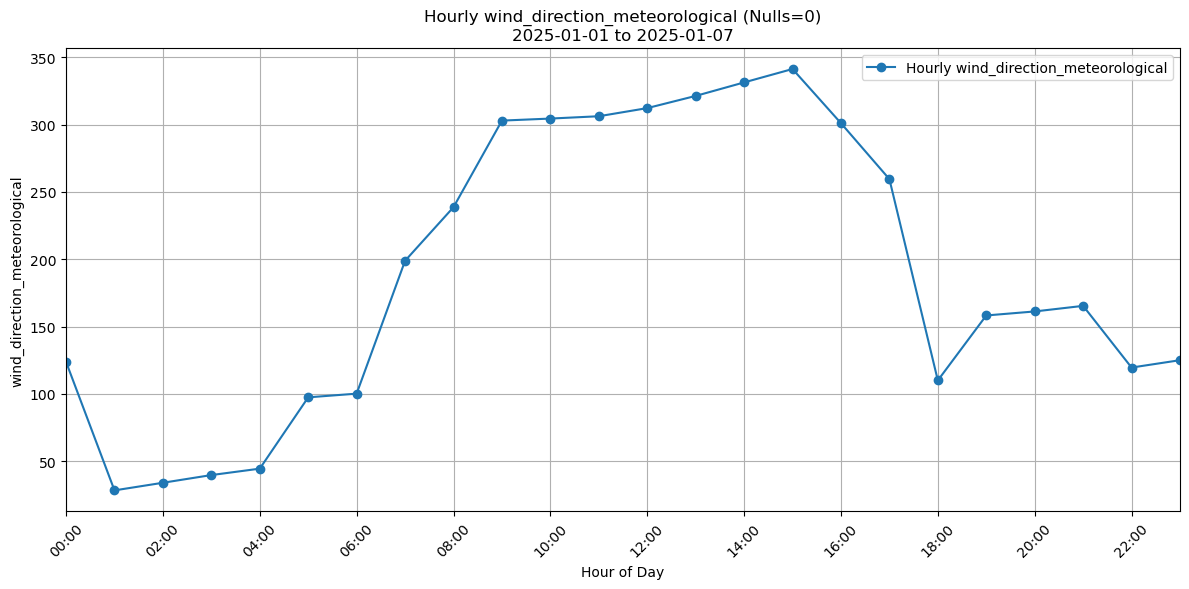

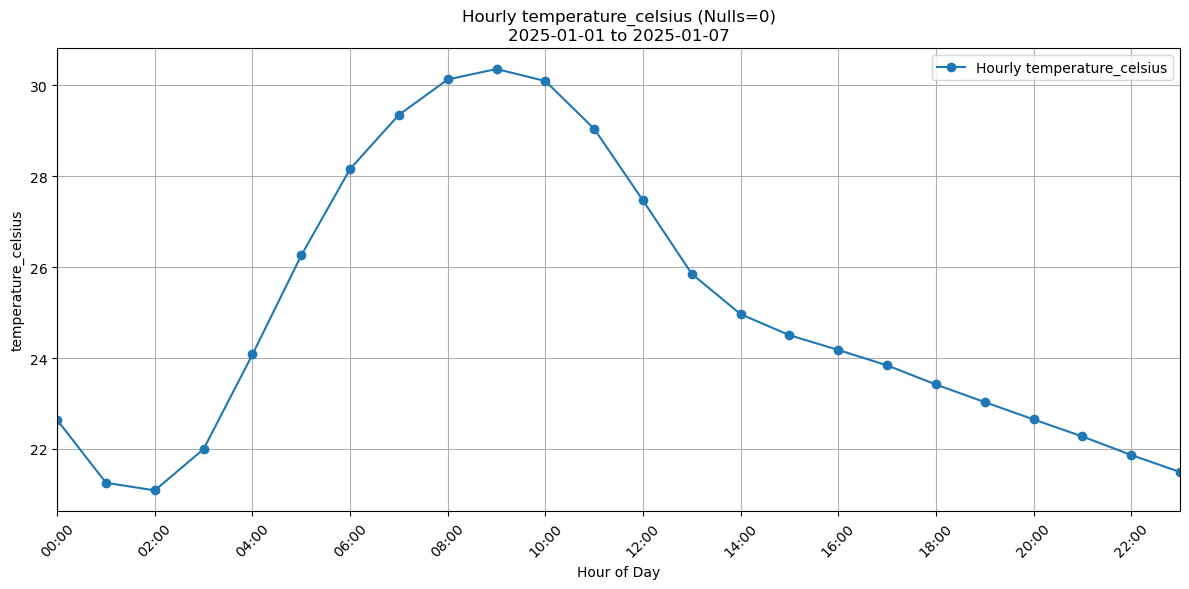

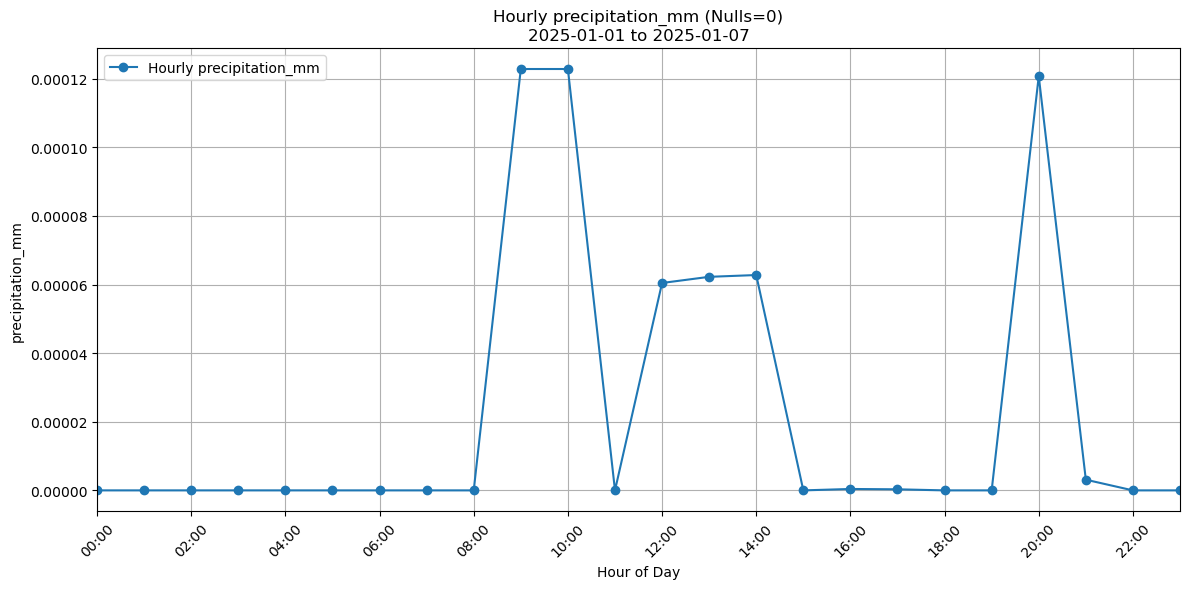

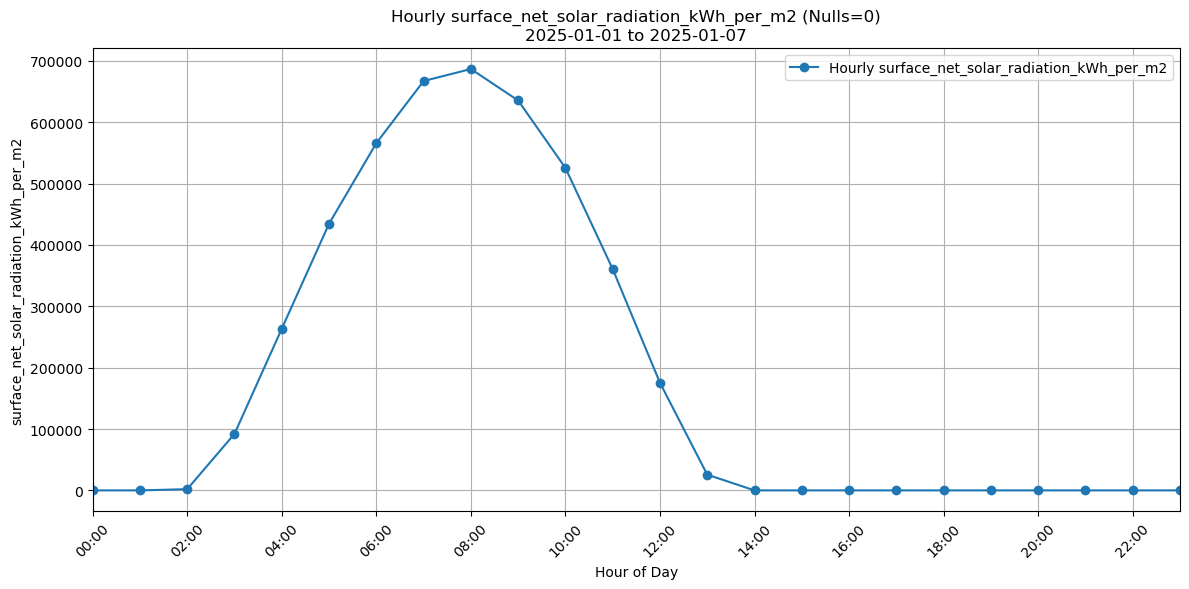

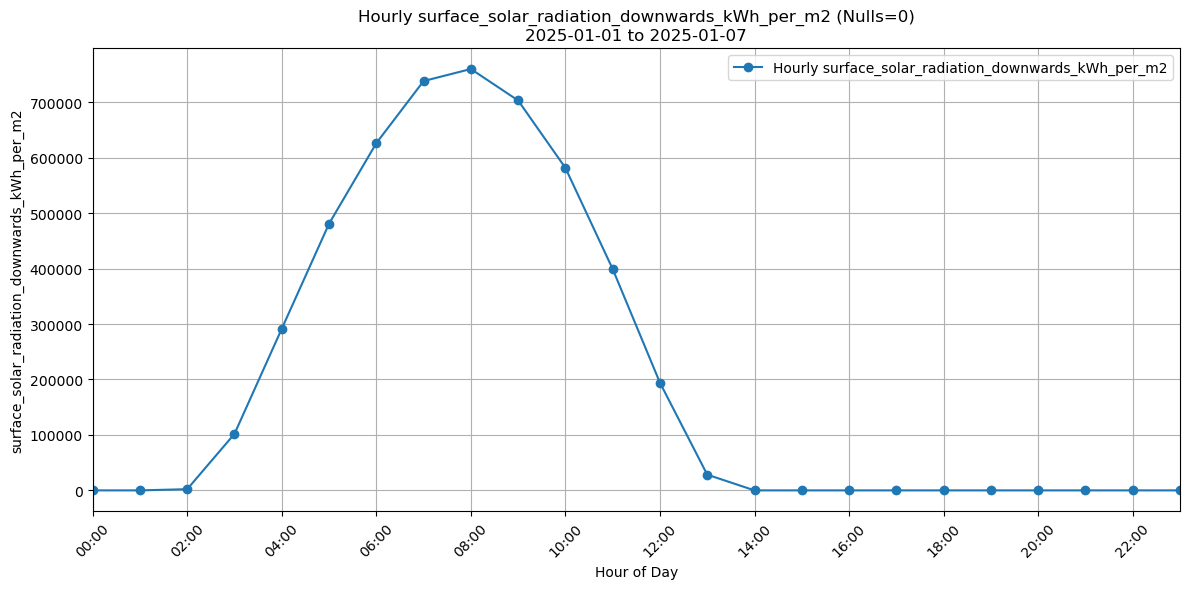

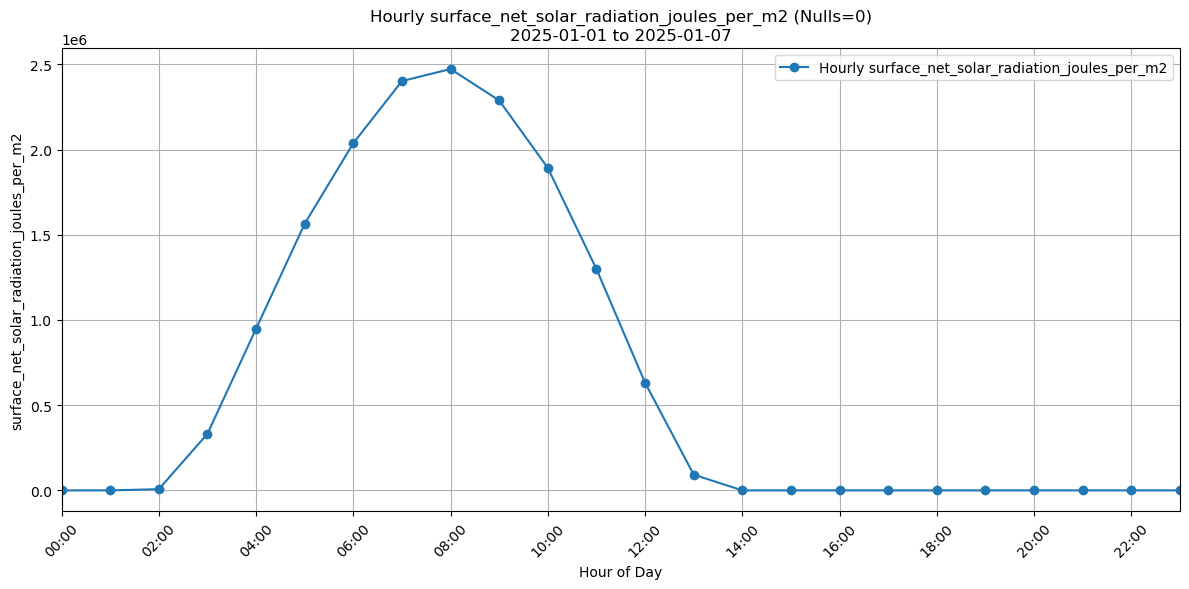

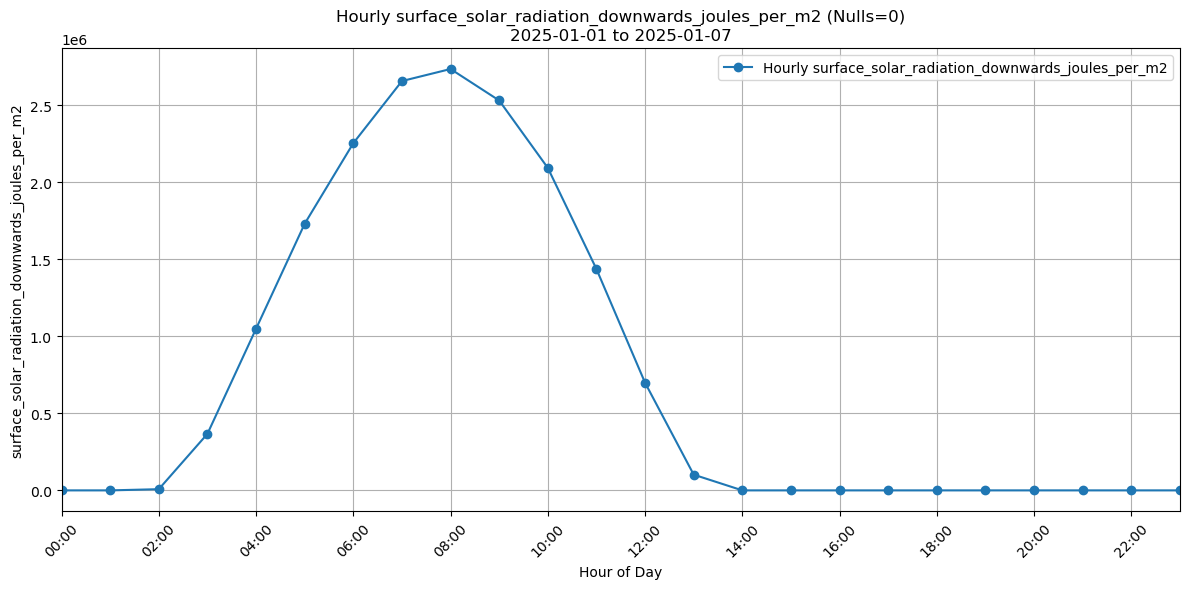

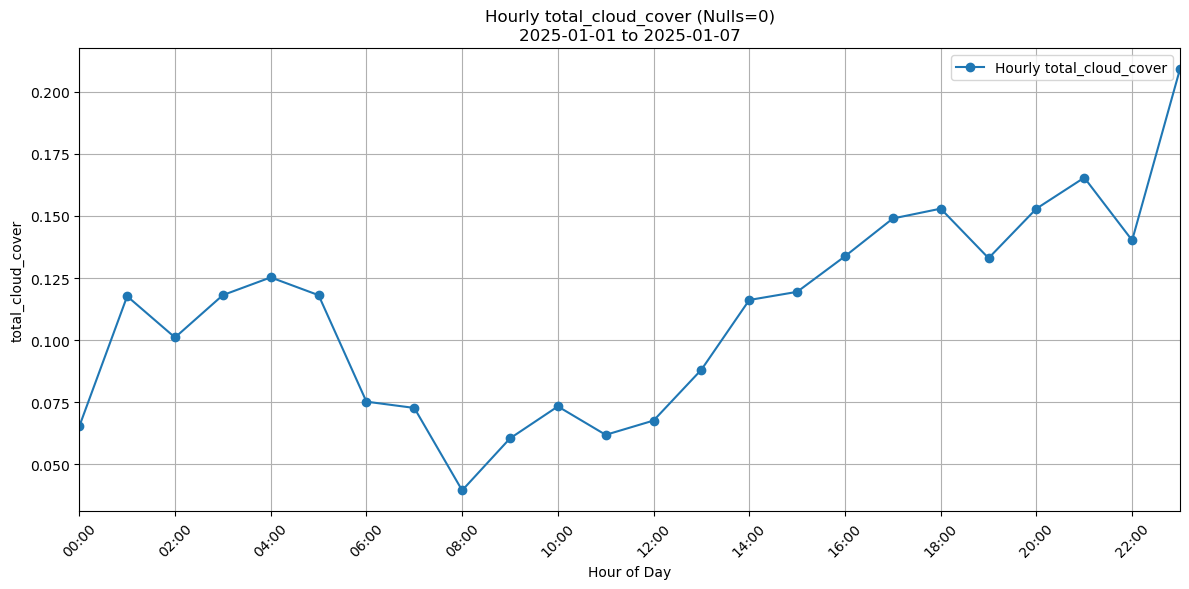

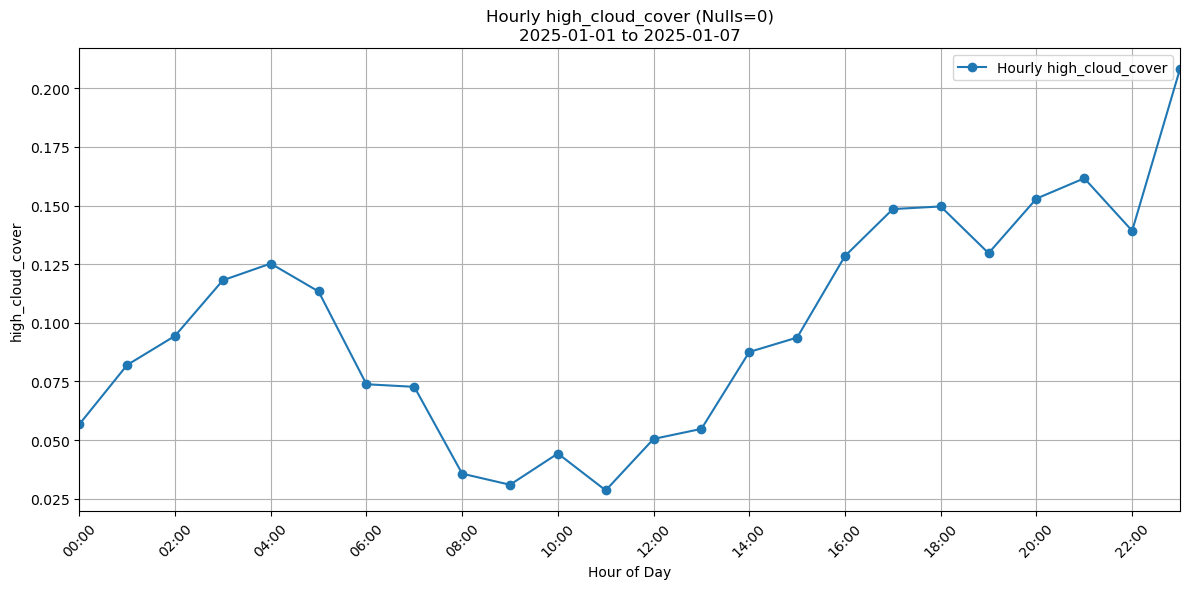

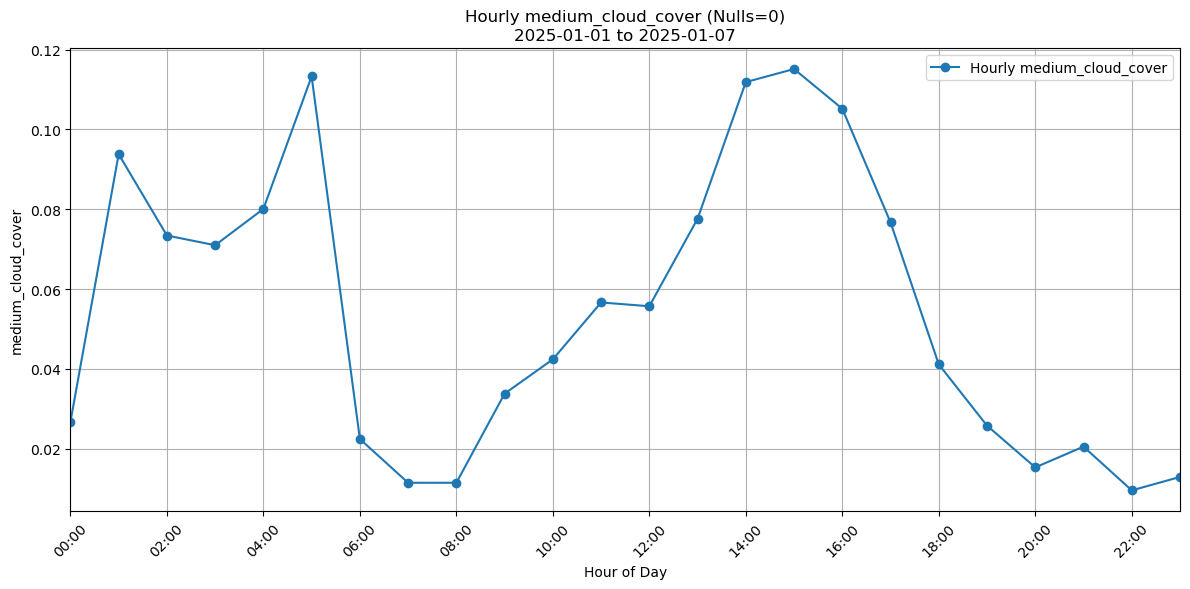

[SKIP] low_cloud_cover: All values are 0 or None


<Figure size 1200x600 with 0 Axes>

In [122]:
plot_hourly_averages(
    filled_intervals_joined_df,
    72.77,
    location_lat=19.2,
    start_date="2025-01-01",
    end_date="2025-01-07",
    variables=[ "wind_speed_mps", "wind_direction_meteorological", "temperature_celsius",
               "precipitation_mm", "surface_net_solar_radiation_kWh_per_m2",
               "surface_solar_radiation_downwards_kWh_per_m2", "surface_net_solar_radiation_joules_per_m2",
               "surface_solar_radiation_downwards_joules_per_m2", "total_cloud_cover", "high_cloud_cover",
               "medium_cloud_cover", "low_cloud_cover"],
    longitude_col_name="land_longitude",
    latitude_col_name="land_latitude"
)


### Summary


**Overview**
This notebook consolidates and harmonizes ERA5-Land and ERA5-World weather datasets, filling gaps in the higher-resolution ERA5-Land data using the more complete ERA5-World reanalysis data. The combined dataset provides comprehensive meteorological variables for Delhi and Mumbai regions with enhanced completeness and reliability.



**Data Structure and Integration**
- **Spatial Relationship**: ERA5-Land provides higher-resolution (0.1°) data but with more gaps, while ERA5-World offers complete coverage at lower resolution (originally 0.25°, but regridded to 0.1°)
- **Temporal Coverage**: Both datasets span 2020-2025 at hourly intervals
- **Mapping**: Each ERA5-Land location was mapped to its nearest ERA5-World grid point using spatial joining

**Data Quality Issues**
- **Missing Patterns Identified**:
  - Midnight (00:00) readings consistently missing in ERA5-Land data
  - Accumulated variables (precipitation, solar radiation) showing daily reset patterns
  - Extended gaps during specific time periods (2022-10-31 to 2023-04-01)
  - Isolated nulls scattered throughout the dataset (midnight)


**Processing Pipeline**
1. **Spatial Coordination**:
   - Created explicit mapping between ERA5-Land and ERA5-World locations
   - Added world coordinate reference to each land location for joining

2. **Temporal Gap Filling** (Multi-stage):
   - Filled midnight (00:00) values using ERA5-World data
   - Addressed consecutive gaps in instantaneous variables (temperature, wind speed/direction)
   - Processed accumulated variables to create hourly increments

3. **Variable Transformation**:
   - Deaccumulated precipitation and radiation measurements
   - Created interval versions of cumulative fields
   - Added cloud cover variables from ERA5-World (total, high, medium, low)

4. **Audit Tracking**:
   - Added processing logs for each transformation


**Further Processing**:
   - Time zone conversion to local time (IST) needed for next steps
